In [2]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import glob

### AR(1)

In [18]:
fve_0_99_df = pd.read_parquet("multi_model_1000_0.99_10000_100_RMSE_0.95_600_1/results.parquet")

In [4]:
def find_pareto_front_hyperidx(x:np.ndarray, y:np.ndarray):
    paretof_hyper_idxs = []
    i = np.argmin(y)
    paretof_hyper_idxs.append(i)
    while np.any(x < x[i]):
        idx = np.argwhere(x < x[i])
        i0 = np.argmin(y[idx])
        i = idx[i0][0]
        paretof_hyper_idxs.append(i)
    x_boundary = np.array(x[paretof_hyper_idxs]) 
    y_boundary = np.array(y[paretof_hyper_idxs]);

    x_enhanced_boundary = np.array(x[paretof_hyper_idxs])
    y_enhanced_boundary = np.array(y[paretof_hyper_idxs]);
    
    n_b = x_boundary.size
    x_boundary = np.insert(x_boundary,[0,n_b],[np.max(x),np.min(x)]);
    y_boundary = np.insert(y_boundary,[0,n_b],[np.min(y),np.max(y)]);
    
    n_eb = x_enhanced_boundary.size
    idx = np.arange(0,(n_eb-1))
    x_enhanced_boundary = np.insert(x_enhanced_boundary,idx+1,x_enhanced_boundary[idx])
    y_enhanced_boundary = np.insert(y_enhanced_boundary,idx+1,y_enhanced_boundary[idx+1])
    n_eb = x_enhanced_boundary.size
    x_enhanced_boundary = np.insert(x_enhanced_boundary,[0,n_eb],[np.max(x),np.min(x)]);
    y_enhanced_boundary = np.insert(y_enhanced_boundary,[0,n_eb],[np.min(y),np.max(y)]);
   
    
    return paretof_hyper_idxs, x_boundary, y_boundary, x_enhanced_boundary, y_enhanced_boundary 

In [5]:
def make_pareto_frontier_plot(results: pd.DataFrame, h: list[int], metric: str, title: str, alpha = 1,
                              log_scale: bool=False, add_oracle_NRMSE_line: bool=False, fve: float=np.nan) -> tuple[ggplot, list[int]]:
    results = results[results["h"].isin(h)].copy()

    results = results.groupby(["hyper_idx"]).agg(
        mean_squared_error=("squared_error", "mean"),
        RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
        coverage_accuracy=("coverage_flags", "mean"),
        flops = ("flops", "mean"),
        num_params = ("num_params", "mean"),
        sd = ("sd", "mean")
    )

    results["normalized_rmse"] = results["RMSE"] / results["sd"]
    if metric == "flops":
        xlab = "Flops (K)"
    else:
        xlab = "Number of Parameters (K)"

    results.reset_index(drop=False, inplace=True)
    pareto_hyper_idx, x_b, y_b, x_eb, y_eb= find_pareto_front_hyperidx(results[metric].values, results["normalized_rmse"].values)
    results["boundary_flags"] = results["hyper_idx"].isin(pareto_hyper_idx)
    
    boundary_df = pd.DataFrame({metric: x_b, "normalized_rmse": y_b})
    enhanced_boundary_df = pd.DataFrame({metric: x_eb[:-1], "normalized_rmse": y_eb[:-1],
                                         "metric_end": x_eb[1:], "normalized_rmse_end": y_eb[1:]})

    plot = (
        ggplot(results, aes(x = metric, y = "normalized_rmse")) +
        geom_point(alpha = alpha) +
        geom_point(results[results["boundary_flags"]], color = "blue", size = 2) + 
        geom_segment(aes(x = metric, y = "normalized_rmse", xend = "metric_end", yend = "normalized_rmse_end"),
                     data = enhanced_boundary_df, color = "red") +
        # geom_line(boundary_df, aes(x = metric, y = "normalized_rmse"), color = "red") + 
        # geom_line(enhanced_boundary_df, aes(x = metric, y = "normalized_rmse"), color = "blue") +
        labs(x = xlab, y = "Normalized RMSE", title=title) +
        theme_bw()
    )

    # plt.plot(results[metric], results["normalized_rmse"],".", alpha = alpha)
    # plt.plot(x_b,y_b,"r")
    # plt.plot(x_eb,y_eb,"b")
    # plt.xlabel(xlab)
    # plt.ylabel("Normalized RMSE")
    # plt.title(title)
    #plt.show()

    if log_scale:
        plot = plot + scale_x_log10()

    if add_oracle_NRMSE_line:
        plot = plot + geom_hline(yintercept = np.sqrt(1-fve**min(h)), linetype = "dashed")
    boundary_idx = []

    return plot, boundary_idx

In [124]:
title = "AR(1), FVE=0.99, h=10"
plot, _= make_pareto_frontier_plot(fve_0_99_df, list([10]), "flops", title, 0.3, False, True, 0.99)
plot

arima_df = pd.read_parquet("ARIMA_model_1_0.99_10000_100_RMSE_0.95_600_1/results.parquet")
arima_df = arima_df[arima_df["h"].isin(([50]))].copy()
arima_df = arima_df.groupby("hyper_idx").agg(
    mean_squared_error=("squared_error", "mean"),
    RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
    sd = ("sd", "mean")
)
print(arima_df)
arima_df["normalized_rmse"] = arima_df["RMSE"] / arima_df["sd"]
arima_df

           mean_squared_error      RMSE         sd
hyper_idx                                         
0                   48.033611  6.930628  10.512966


mean_squared_error      RMSE         sd  normalized_rmse
hyper_idx                                                          
0                   48.033611  6.930628  10.512966         0.659246

In [181]:
def make_pareto_frontier_plot_ar1(results: pd.DataFrame, h: list[int], metric: str, title: str, alpha = 1,
                              log_scale: bool=False, add_oracle_NRMSE_line: bool=False, fve: float=np.nan) -> tuple[ggplot, list[int]]:

    arima_df = pd.read_parquet(f"ARIMA_model_1_{fve}_10000_100_RMSE_0.95_600_1/results.parquet")
    arima_df = arima_df[arima_df["h"].isin(h)].copy()
    arima_df = arima_df.groupby("hyper_idx").agg(
        mean_squared_error=("squared_error", "mean"),
        RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
        sd = ("sd", "mean")
    )
    arima_df["normalized_rmse"] = arima_df["RMSE"] / arima_df["sd"]
    
    results = results[results["h"].isin(h)].copy()

    results = results.groupby(["hyper_idx"]).agg(
        mean_squared_error=("squared_error", "mean"),
        RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
        coverage_accuracy=("coverage_flags", "mean"),
        flops = ("flops", "mean"),
        num_params = ("num_params", "mean"),
        sd = ("sd", "mean")
    )

    results["normalized_rmse"] = results["RMSE"] / results["sd"]
    if metric == "flops":
        xlab = "Flops (K)"
    else:
        xlab = "Number of Parameters (K)"

    results.reset_index(drop=False, inplace=True)
    pareto_hyper_idx, x_b, y_b, x_eb, y_eb= find_pareto_front_hyperidx(results[metric].values, results["normalized_rmse"].values)
    results["boundary_flags"] = results["hyper_idx"].isin(pareto_hyper_idx)
    
    boundary_df = pd.DataFrame({metric: x_b, "normalized_rmse": y_b})
    enhanced_boundary_df = pd.DataFrame({metric: x_eb[:-1], "normalized_rmse": y_eb[:-1],
                                         "metric_end": x_eb[1:], "normalized_rmse_end": y_eb[1:]})
    if len(h) == 1:
        enhanced_boundary_df2 = pd.DataFrame({"h": h[0], "metric": metric,
                                              "x": x_eb[:-1], "normalized_rmse": y_eb[:-1],
                                              "x_end": x_eb[1:], "normalized_rmse_end": y_eb[1:]})
        results["h"] = h[0]
       
    else:
        enhanced_boundary_df2 = None

    plot = (
        ggplot(results, aes(x = metric, y = "normalized_rmse")) +
        geom_point(alpha = alpha) +
        geom_segment(aes(x = metric, y = "normalized_rmse", xend = "metric_end", yend = "normalized_rmse_end"),
                     data = enhanced_boundary_df, color = "red") +
        geom_point(results[results["boundary_flags"]], color = "blue", size = 2) + 
        # geom_line(boundary_df, aes(x = metric, y = "normalized_rmse"), color = "red") + 
        # geom_line(enhanced_boundary_df, aes(x = metric, y = "normalized_rmse"), color = "blue") +
        labs(x = xlab, y = "Normalized RMSE", title=title) +
        theme_bw()
    )

    

    if log_scale:
        plot = plot + scale_x_log10()

    if add_oracle_NRMSE_line:
        plot = plot + geom_hline(yintercept = np.sqrt(1-fve**min(h)), linetype = "dashed")
        plot = plot + geom_hline(yintercept = arima_df["normalized_rmse"], linetype = "dotted")
    boundary_idx = []

    return plot, boundary_idx, enhanced_boundary_df2, results

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\IPython\lib\pretty.py:794: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


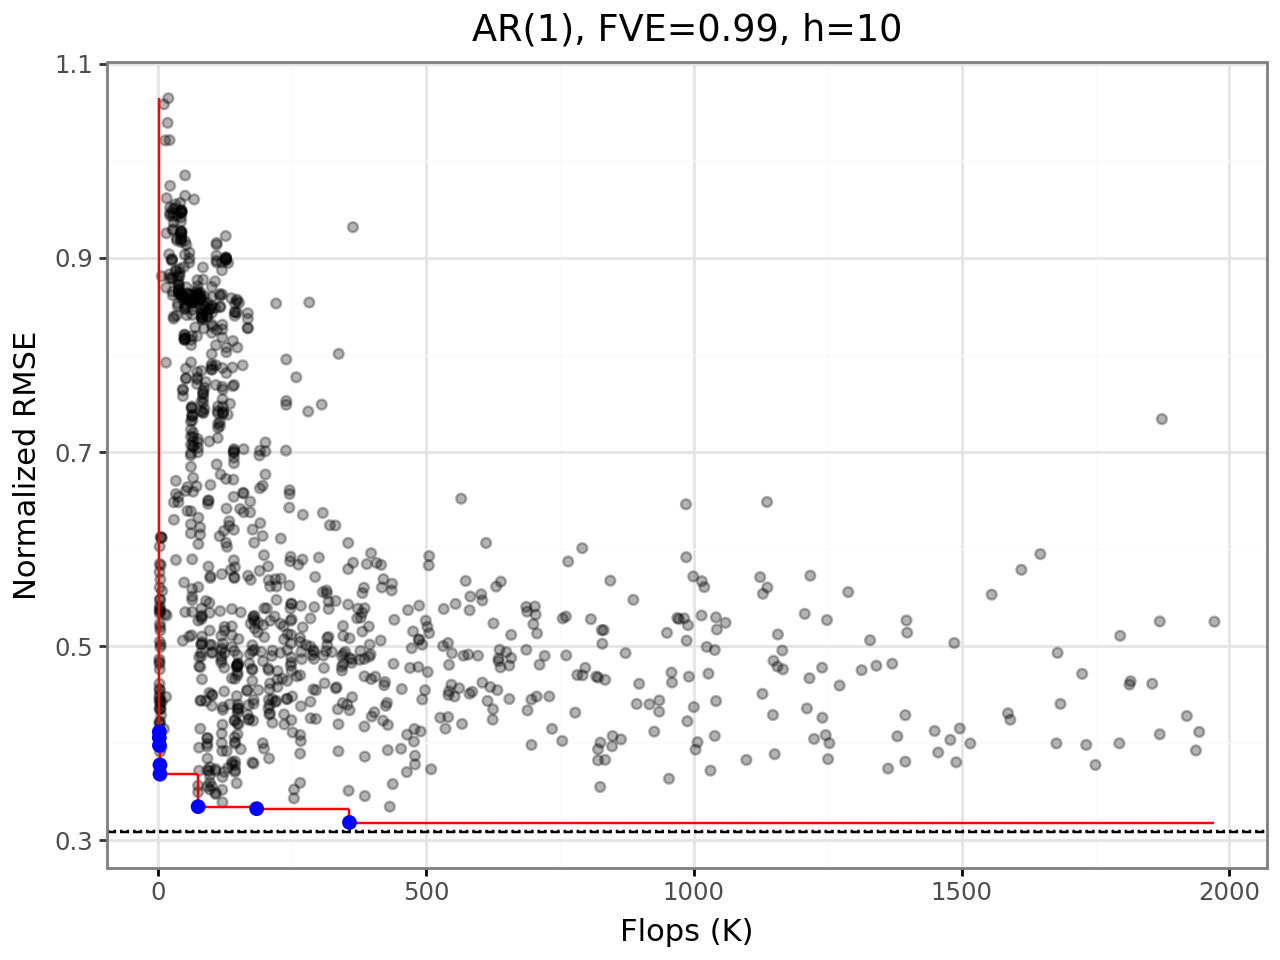

(<Figure Size: (640 x 480)>,
      h metric        x  normalized_rmse   x_end  normalized_rmse_end
 0   10  flops  1972.02         0.318529  357.12             0.318529
 1   10  flops   357.12         0.318529  357.12             0.332755
 2   10  flops   357.12         0.332755  183.76             0.332755
 3   10  flops   183.76         0.332755  183.76             0.334880
 4   10  flops   183.76         0.334880   74.54             0.334880
 5   10  flops    74.54         0.334880   74.54             0.368357
 6   10  flops    74.54         0.368357    3.28             0.368357
 7   10  flops     3.28         0.368357    3.28             0.377845
 8   10  flops     3.28         0.377845    3.22             0.377845
 9   10  flops     3.22         0.377845    3.22             0.397997
 10  10  flops     3.22         0.397997    2.28             0.397997
 11  10  flops     2.28         0.397997    2.28             0.405957
 12  10  flops     2.28         0.405957    2.08             

In [12]:
title = "AR(1), FVE=0.99, h=10"
plot, _, enhanced_boundary_df_2 = make_pareto_frontier_plot_ar1(fve_0_99_df, list([10]), "flops", title, 0.3, False, True, 0.99)
plot, enhanced_boundary_df_2


In [184]:
def make_multi_frontier_plot(dfs: list[pd.DataFrame], title: str, result_list: list[pd.DataFrame], fve: float = np.nan) -> ggplot:
    df = pd.concat(dfs)
    results = pd.concat(result_list)
    hs = df["h"].unique()
    line_yintercepts = []
    a = np.arange(1, 300)**(-0.6)

    for h in hs:
        print(fve, h)
        line_yintercept = np.sqrt(1 - fve**h)
        line_yintercepts.append(line_yintercept)

    yintercept_df = pd.DataFrame({"h": hs, "yintercept": line_yintercepts})

   
    df["h"] = pd.Categorical(df["h"])
    yintercept_df["h"] = pd.Categorical(yintercept_df["h"])
    results["h"] = pd.Categorical(results["h"])

    metric = df["metric"].iloc[0]
    if metric == "flops":
        xlab = "Flops (K)"
    else:
        xlab = "Number of Parameters (K)"
    plot = (
        ggplot(df, aes(x = "x", y = "normalized_rmse", xend = "x_end", yend = "normalized_rmse_end", color = "h")) +
        geom_point(aes(x = metric, y = "normalized_rmse", color = "h"), alpha = 0.1, data = results, inherit_aes = False, shape = ".") +
        geom_segment(size = 2) +
        geom_hline(aes(yintercept = "yintercept", color = "h"), data = yintercept_df, linetype = "dashed") +
        labs(x = xlab, y = "Normalized RMSE", title=title) +
        theme_bw()
    )
    return plot

0.1 1
0.1 5
0.1 10
0.1 50


c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 2 rows containing missing values.


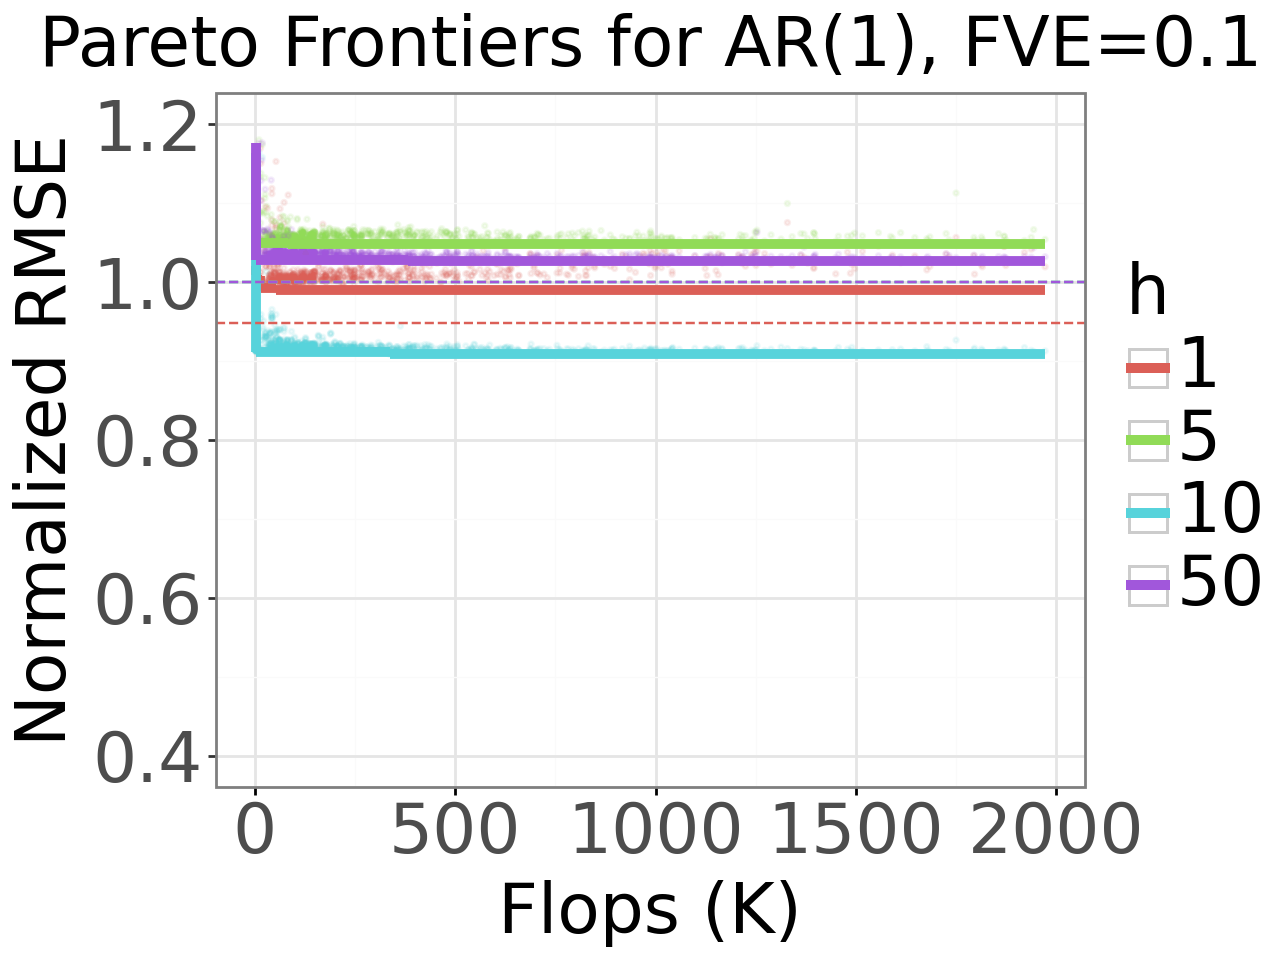

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\ggplot.py:779: PlotnineWarning: Filename: Pareto Frontiers for AR(1), FVE=0.1.pdf
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 2 rows containing missing values.


0.5 1
0.5 5
0.5 10
0.5 50


c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 4 rows containing missing values.


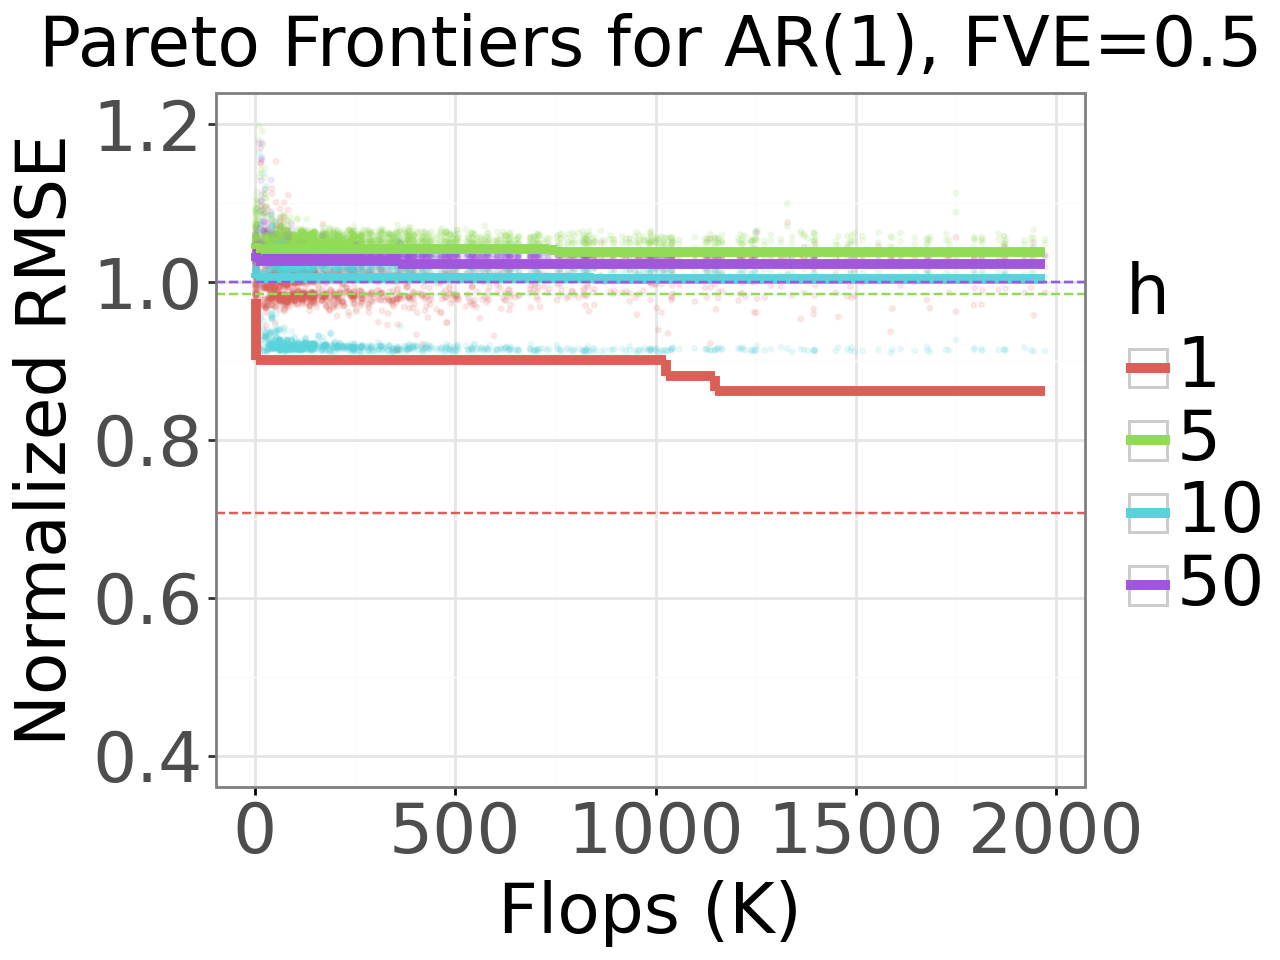

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\ggplot.py:779: PlotnineWarning: Filename: Pareto Frontiers for AR(1), FVE=0.5.pdf
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 4 rows containing missing values.


0.9 1
0.9 5
0.9 10
0.9 50


c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 93 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 6 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_hline : Removed 1 rows containing missing values.


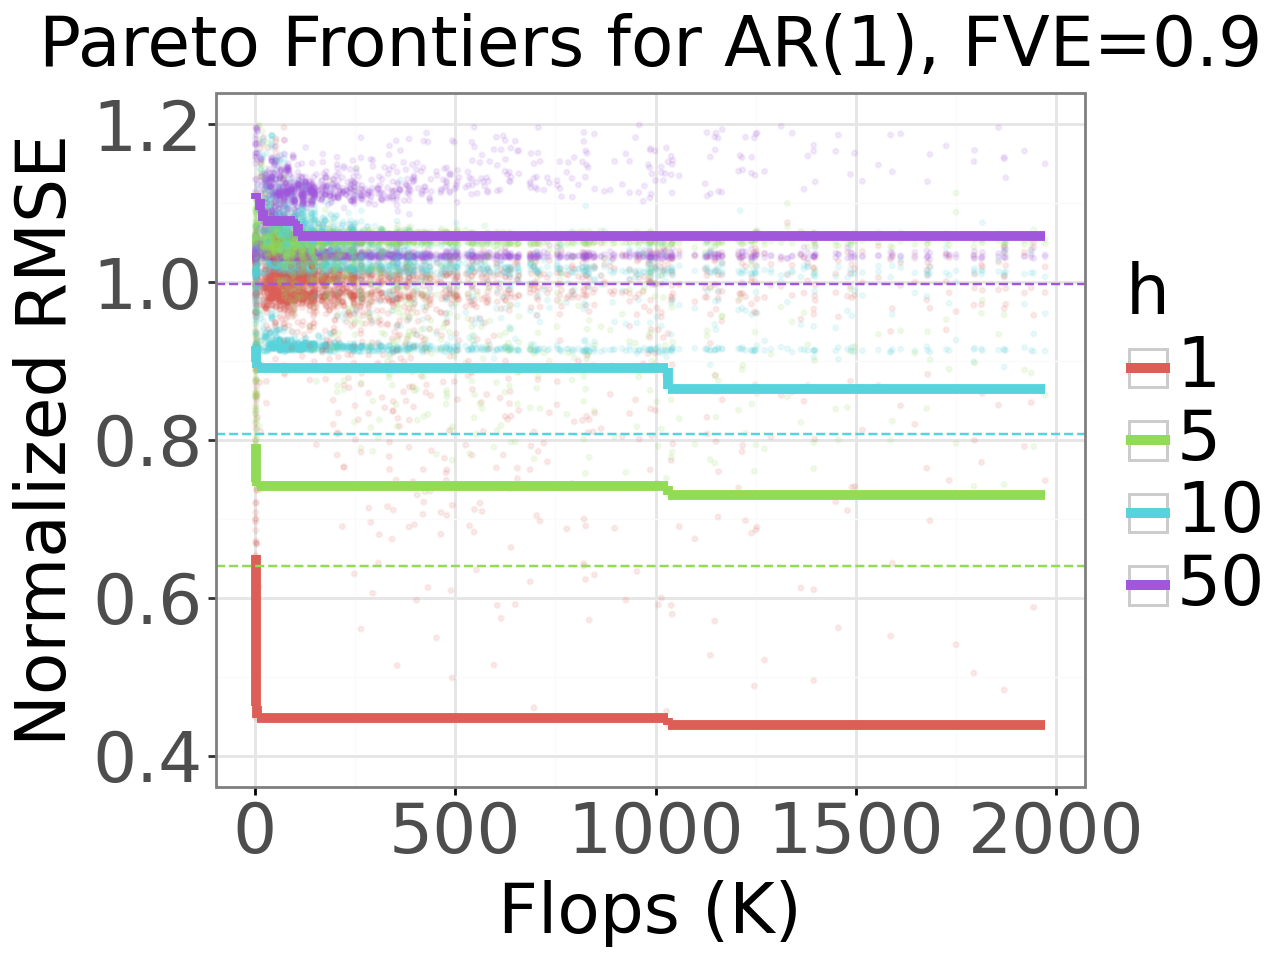

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\ggplot.py:779: PlotnineWarning: Filename: Pareto Frontiers for AR(1), FVE=0.9.pdf
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 93 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 6 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_hline : Removed 1 rows containing missing values.


0.99 1
0.99 5
0.99 10
0.99 50


c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 722 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 38 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_hline : Removed 3 rows containing missing values.


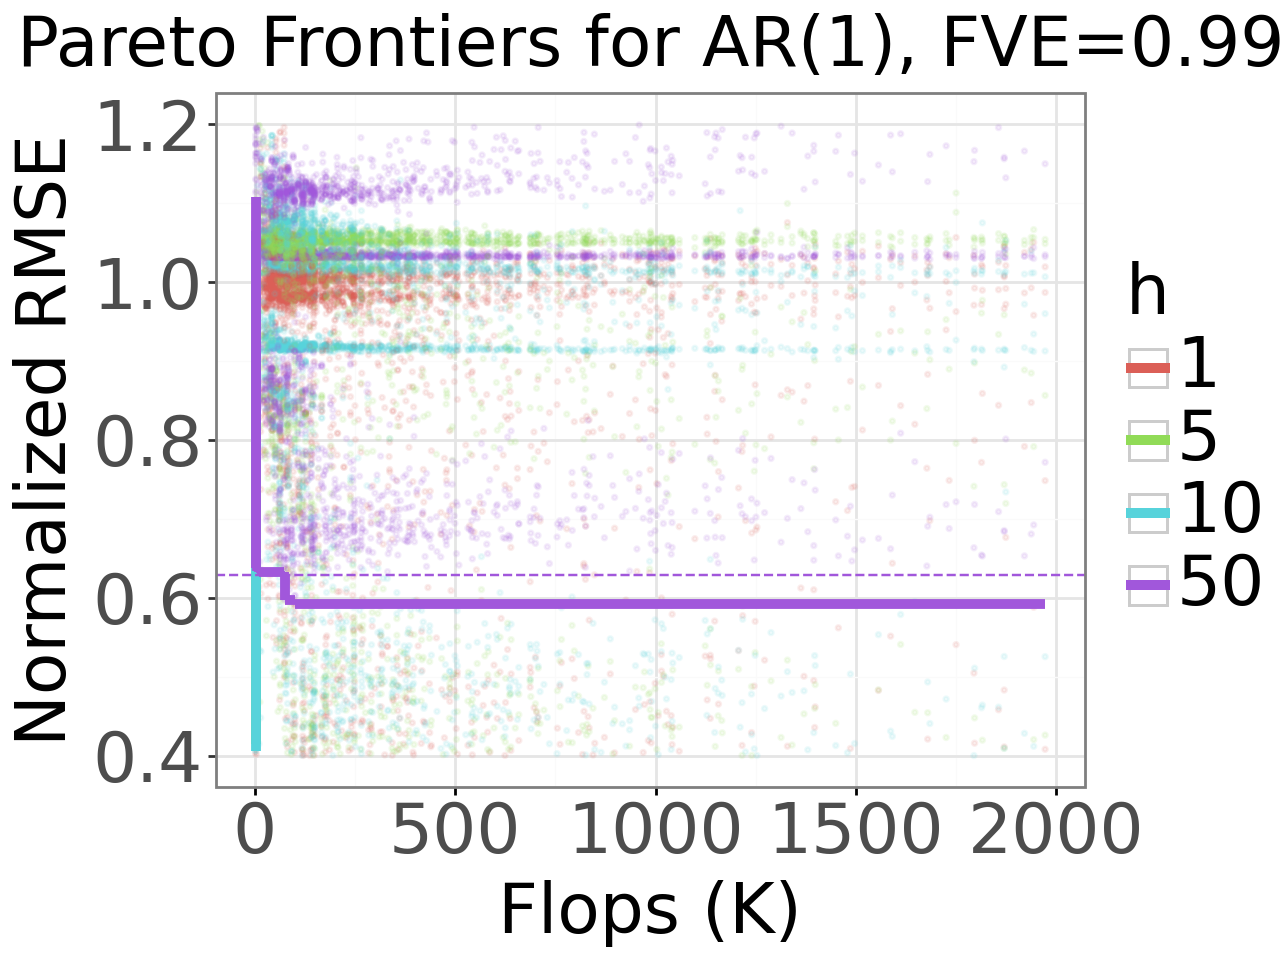

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\ggplot.py:779: PlotnineWarning: Filename: Pareto Frontiers for AR(1), FVE=0.99.pdf
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 722 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 38 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_hline : Removed 3 rows containing missing values.


In [185]:
save = True
hs = [1, 5, 10, 50]
fves = [0.1, 0.5, 0.9, 0.99]

result_list = []
for fve in fves:
    dfs = []
    title = f"Pareto Frontiers for AR(1), FVE={fve}"
    fve_df = pd.read_parquet(f"multi_model_1000_{str(fve)}_10000_100_RMSE_0.95_600_1/results.parquet")
    for h in hs:
        _, _, enhanced_boundary_df_2, results = make_pareto_frontier_plot_ar1(fve_df, [h], "flops", "", 0.3, False, False, fve)
        dfs.append(enhanced_boundary_df_2)
        result_list.append(results)
    plot = make_multi_frontier_plot(dfs, title, result_list, fve) + ylim(0.4, 1.2) + theme(text=element_text(size=25))
    plot.show()
    if save:
        save_as_pdf_pages([plot], f"{title}.pdf")

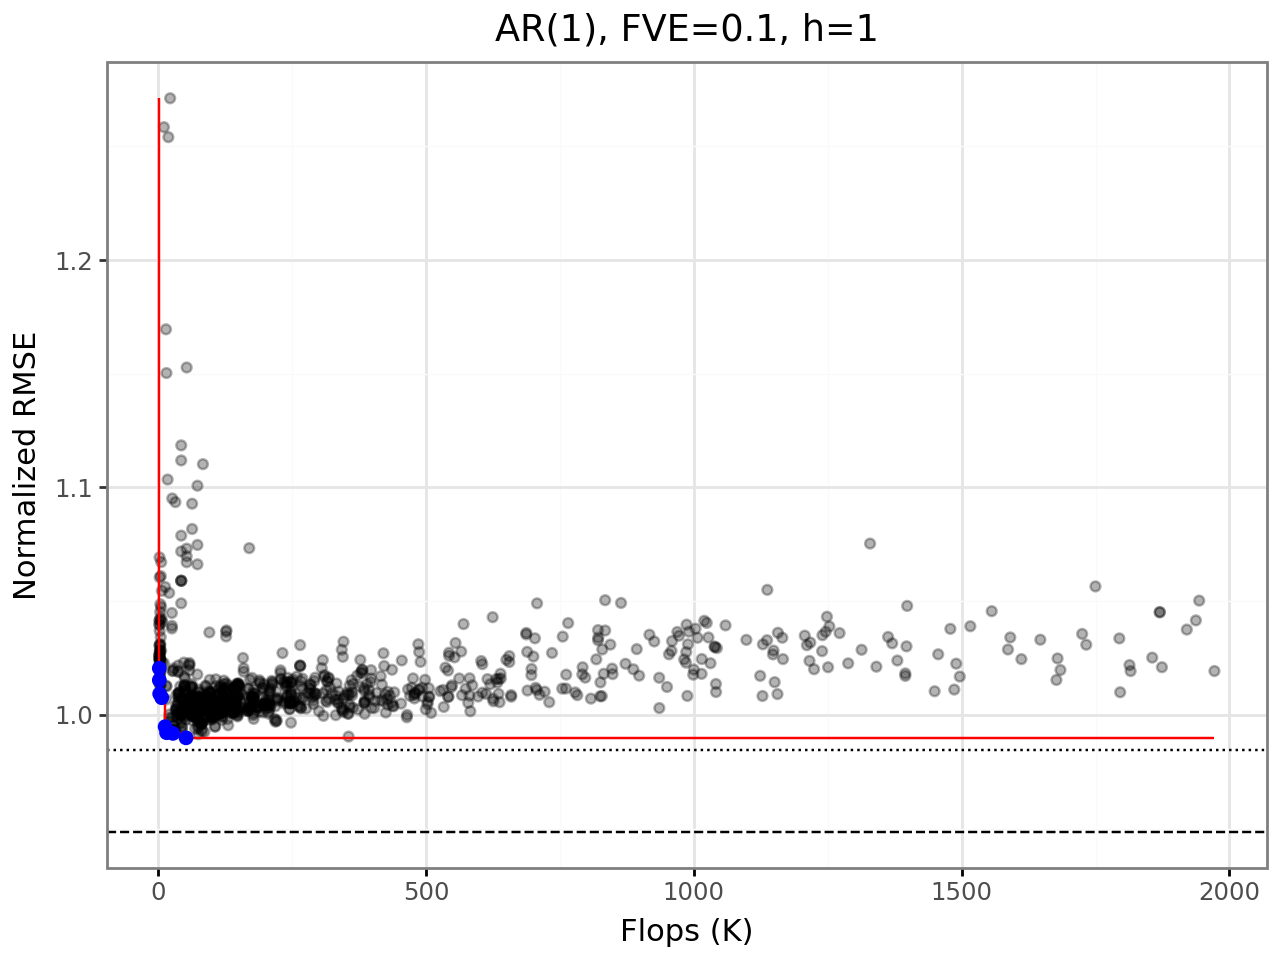

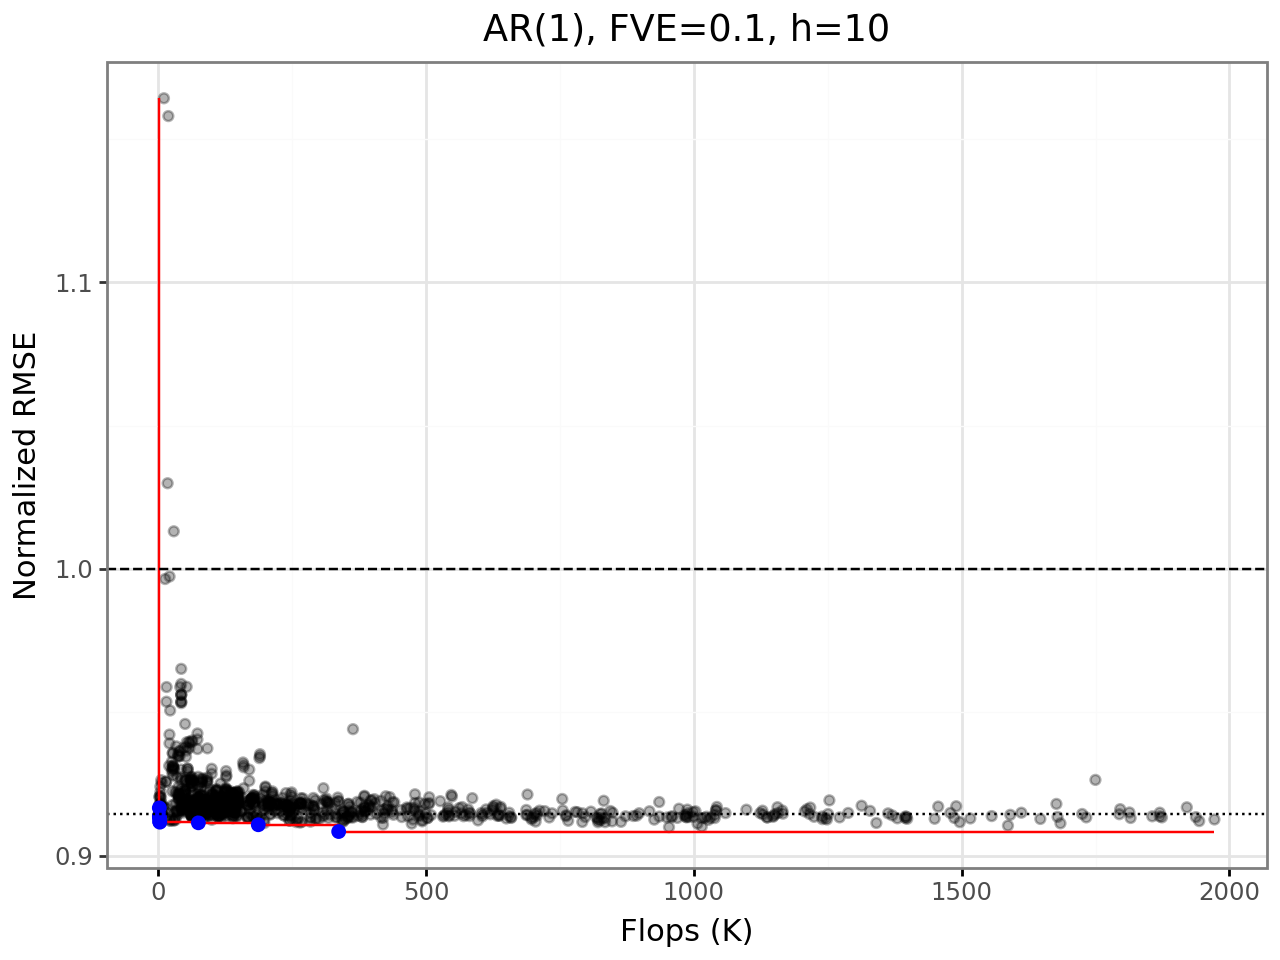

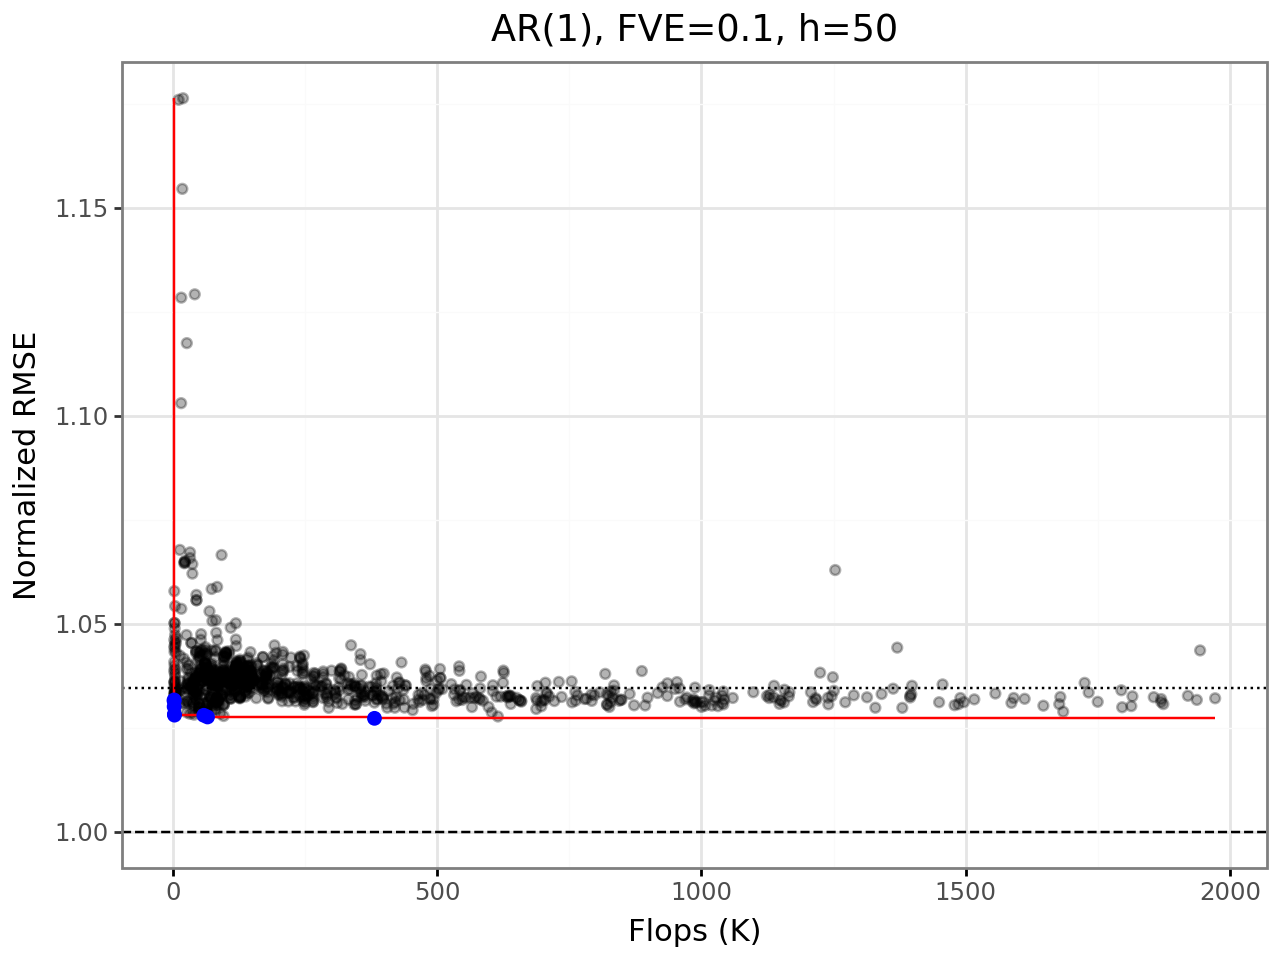

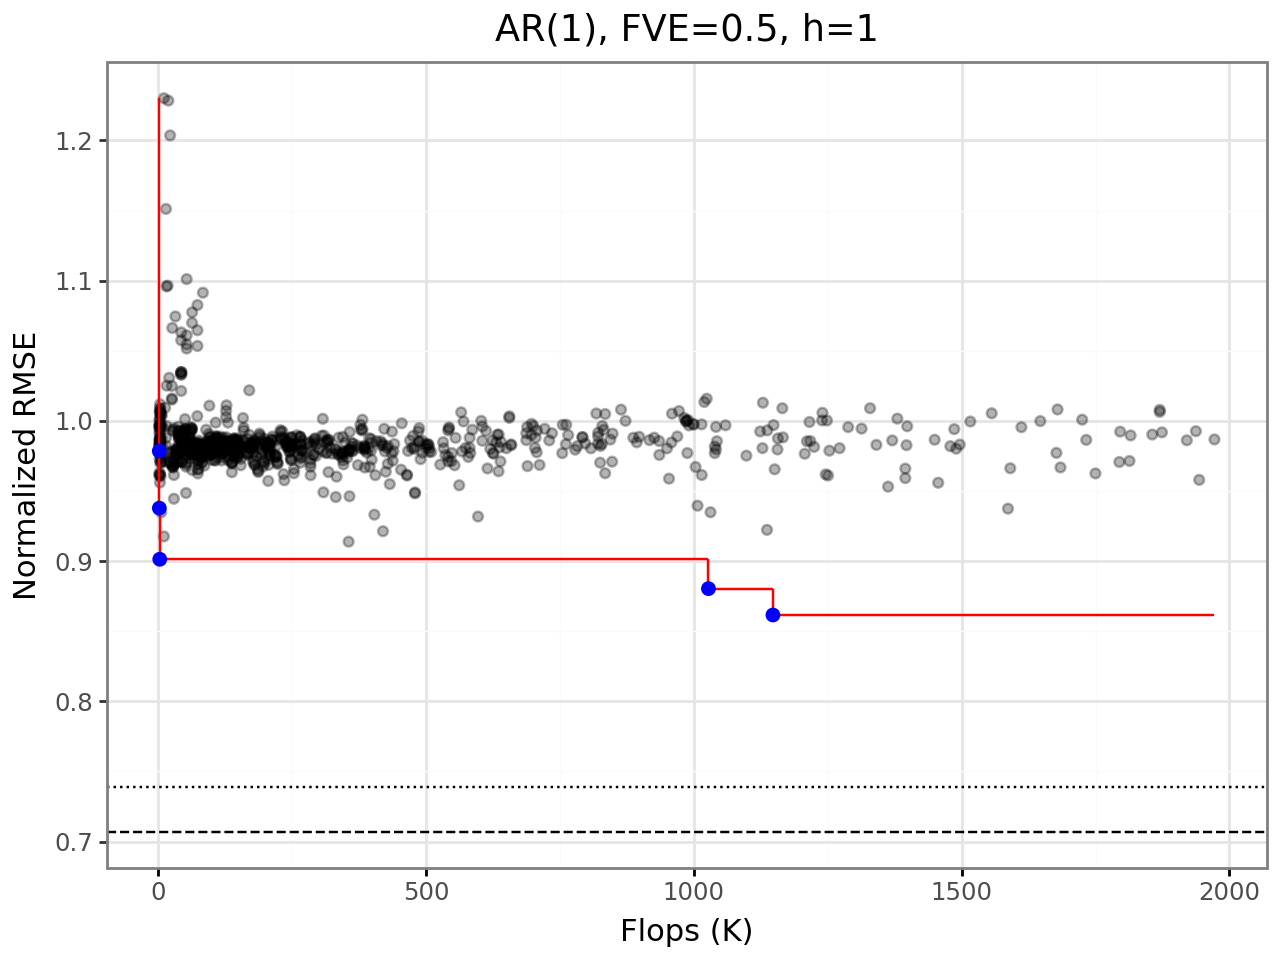

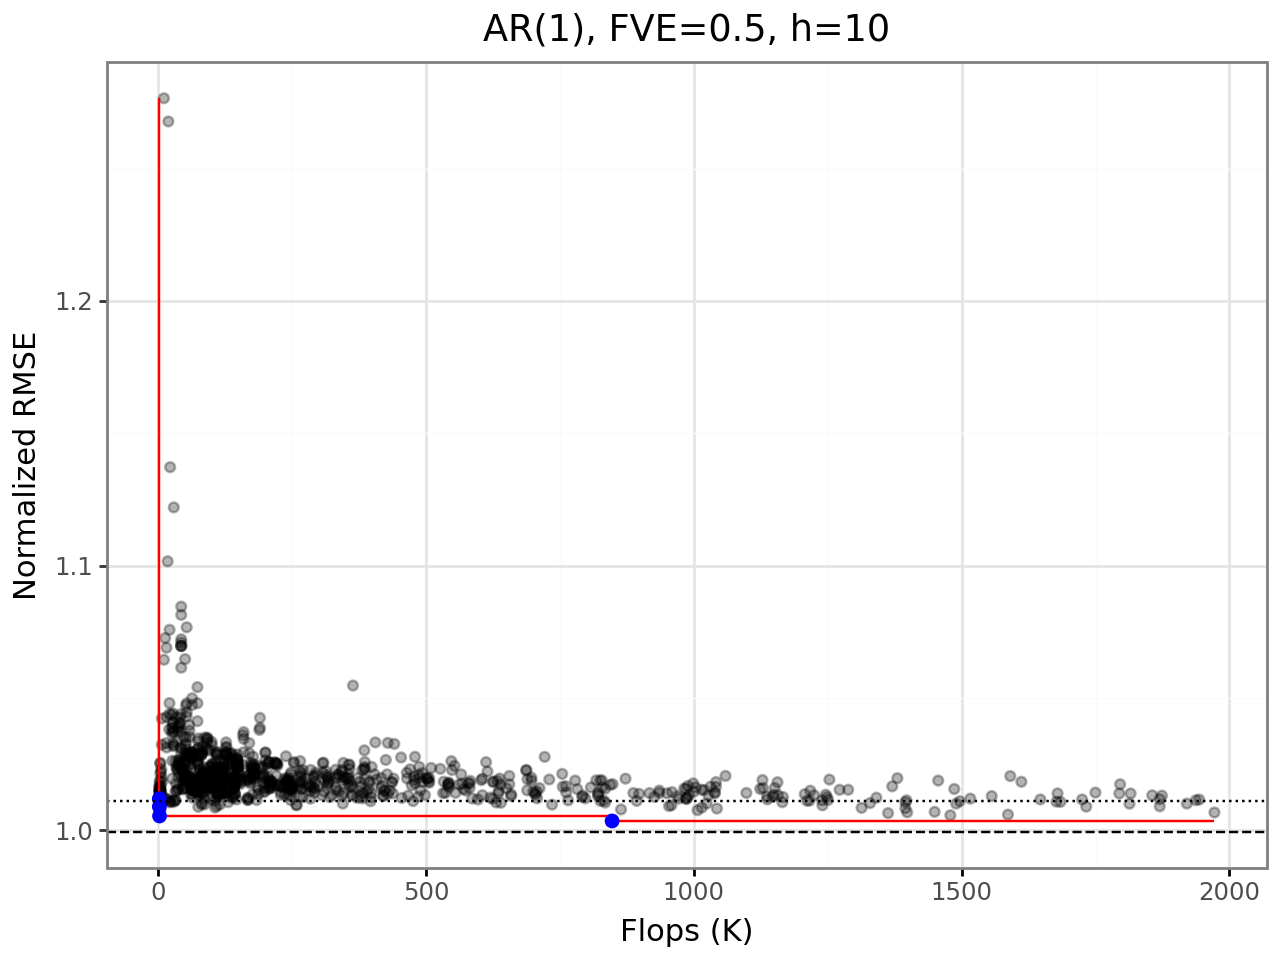

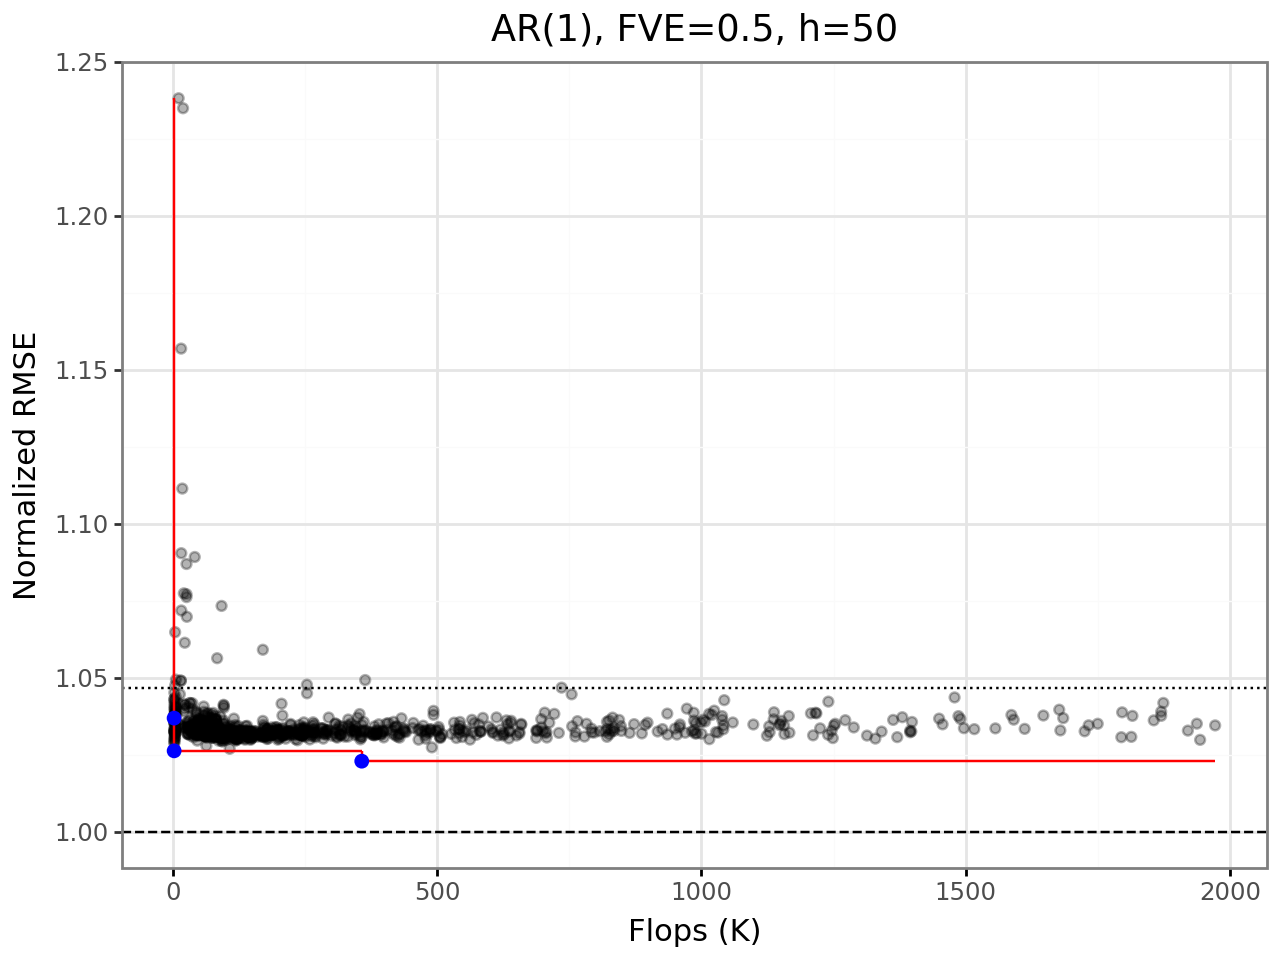

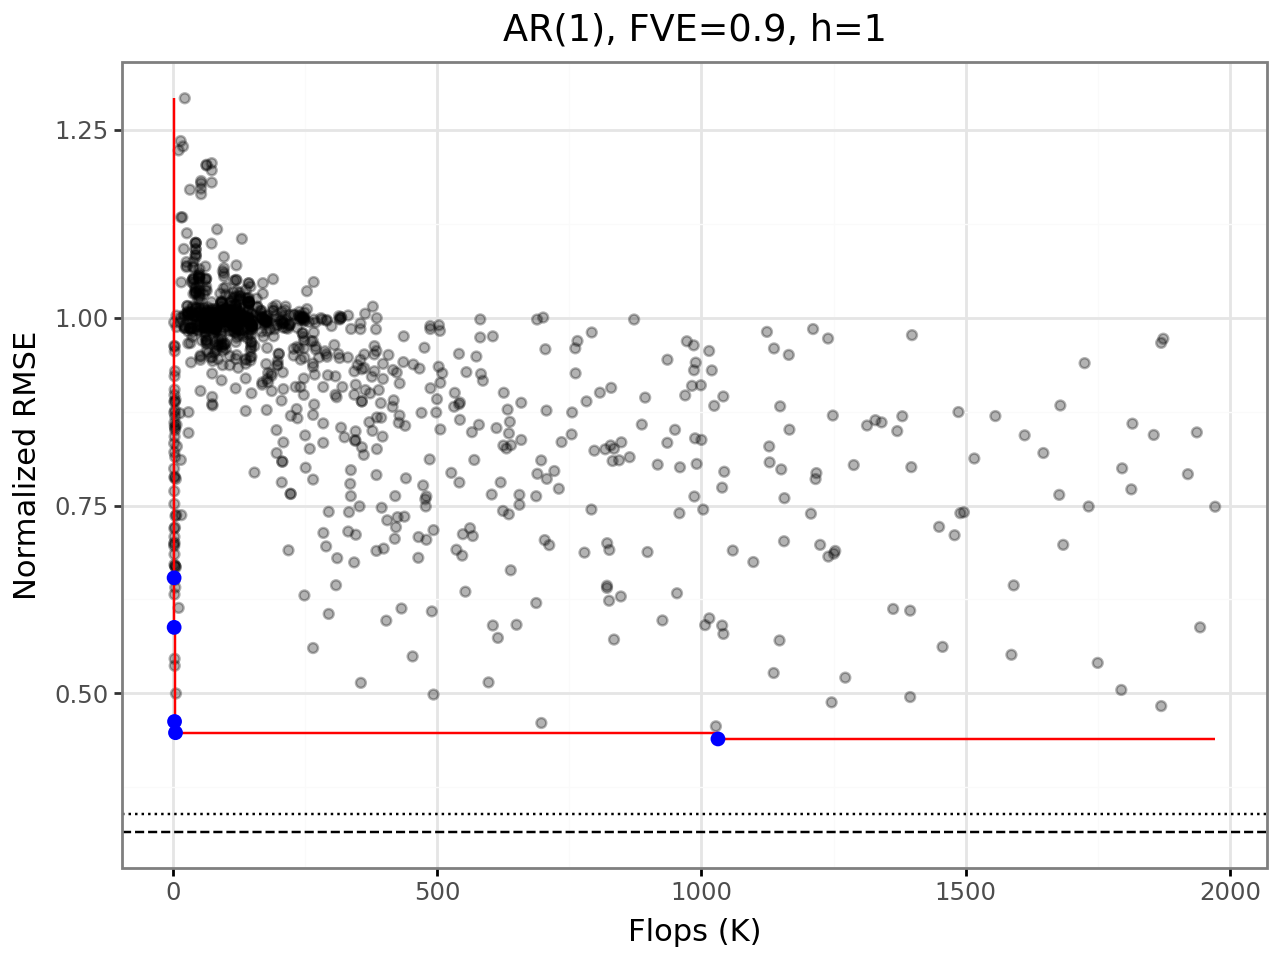

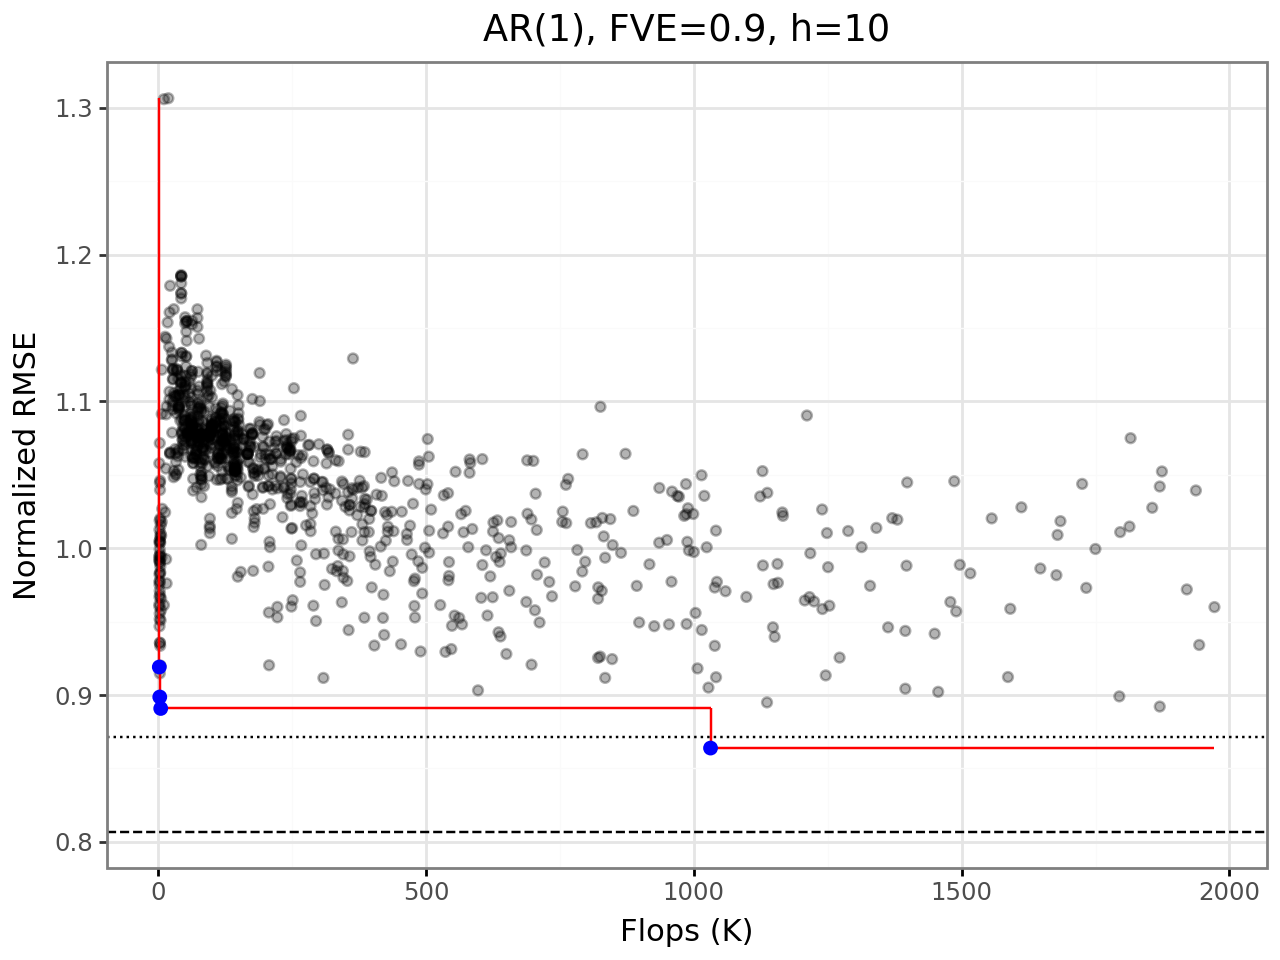

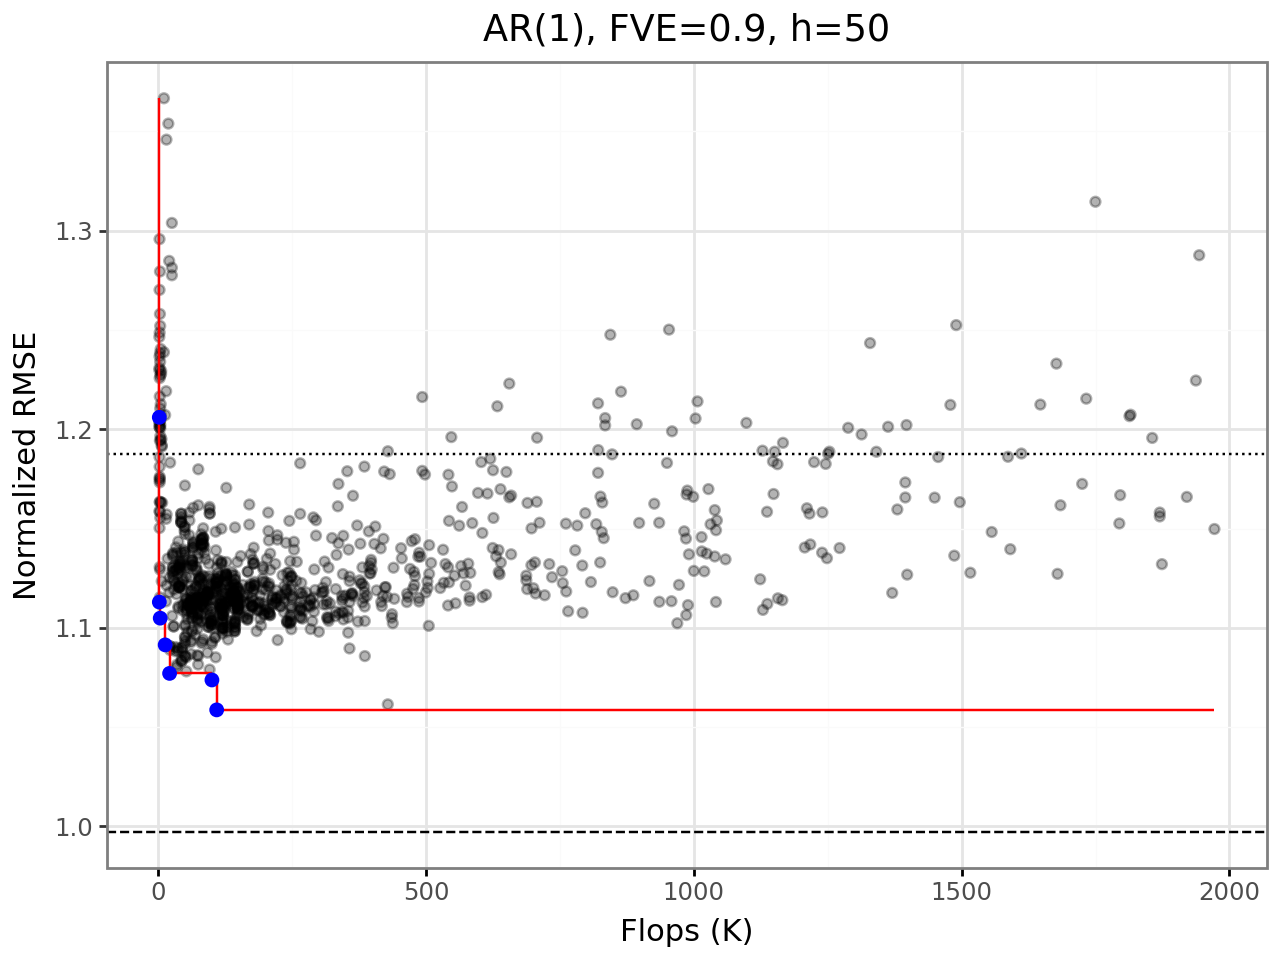

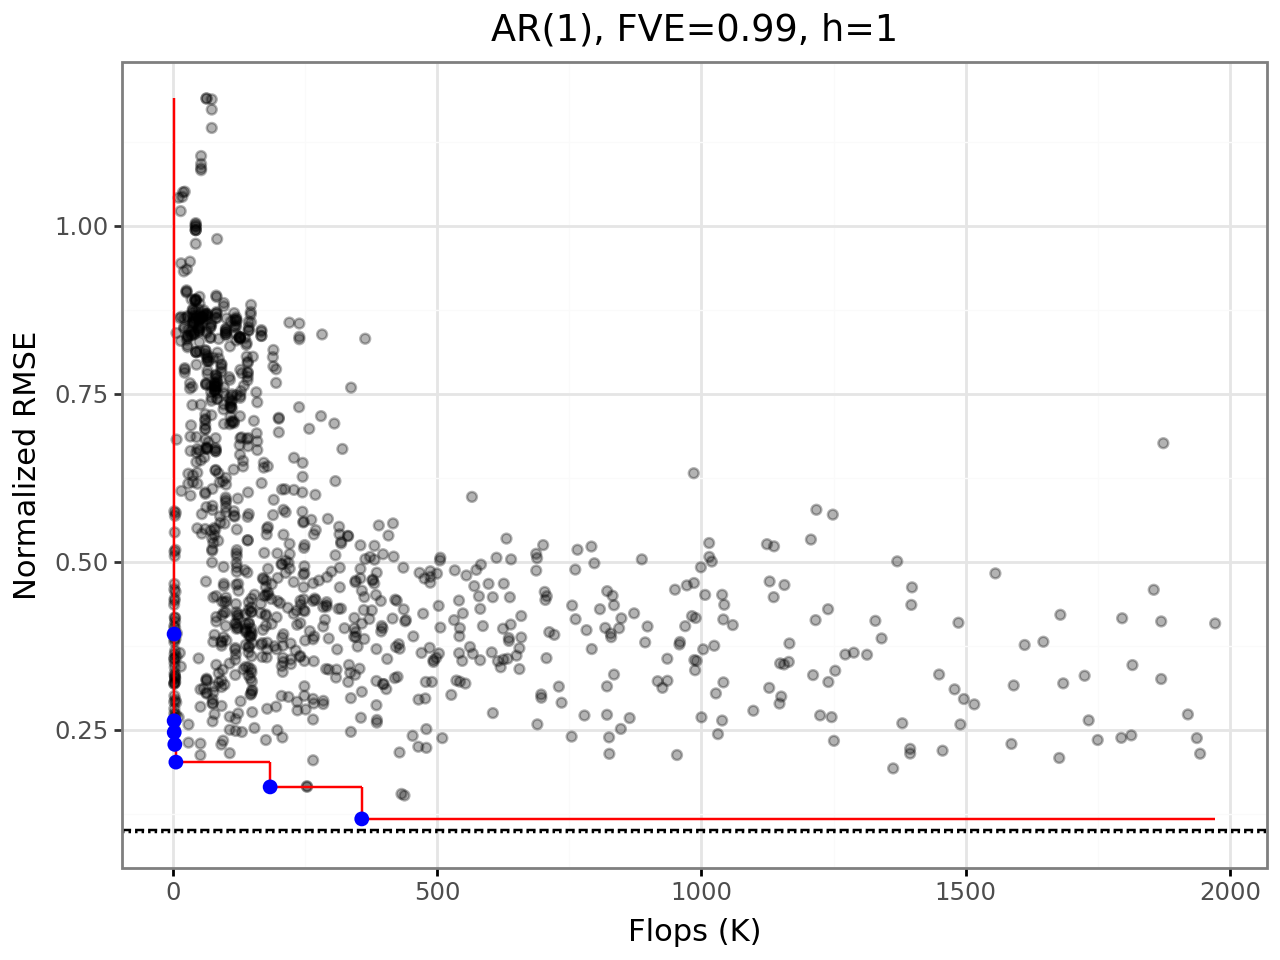

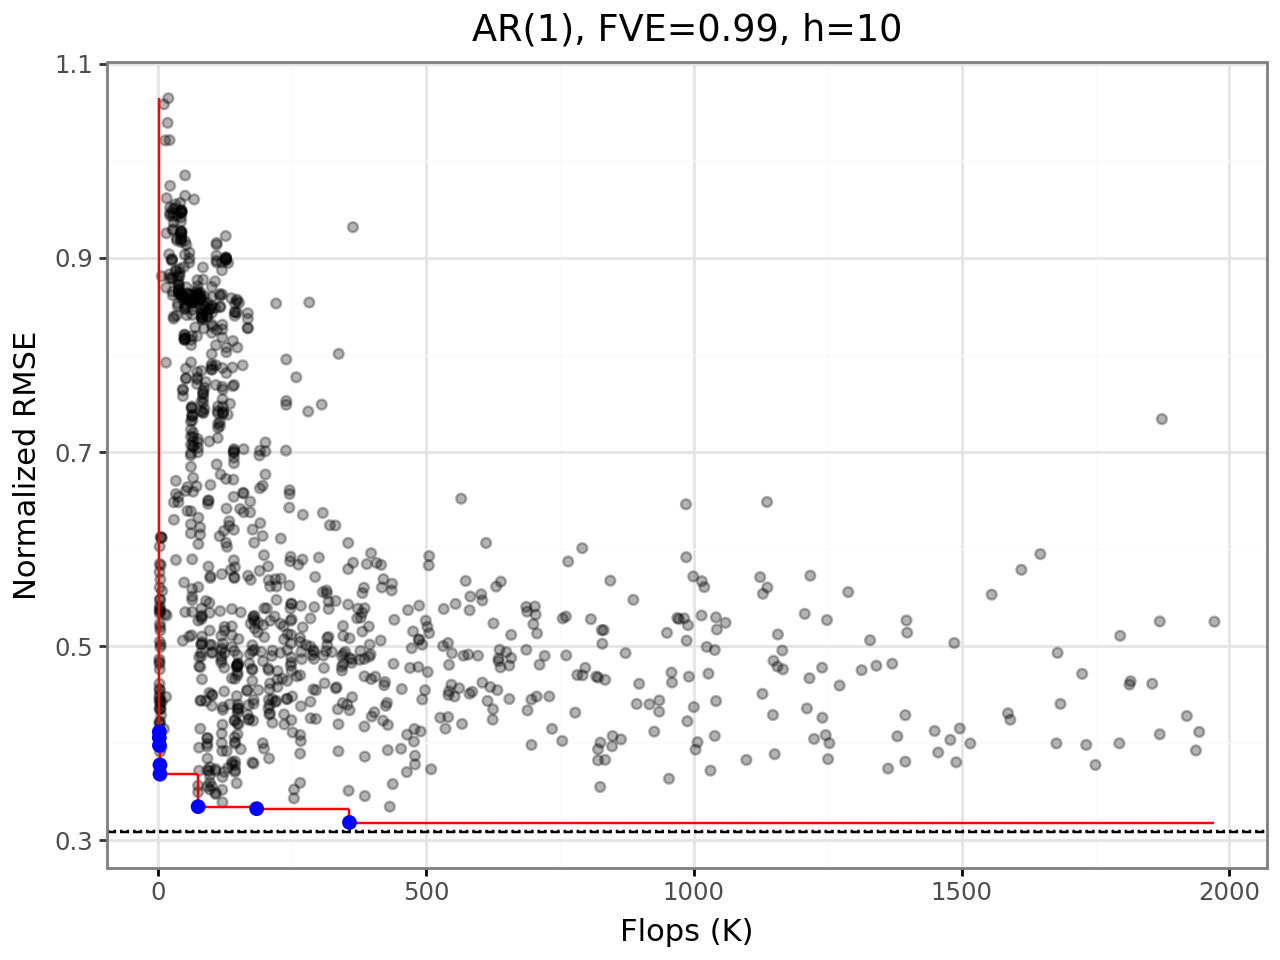

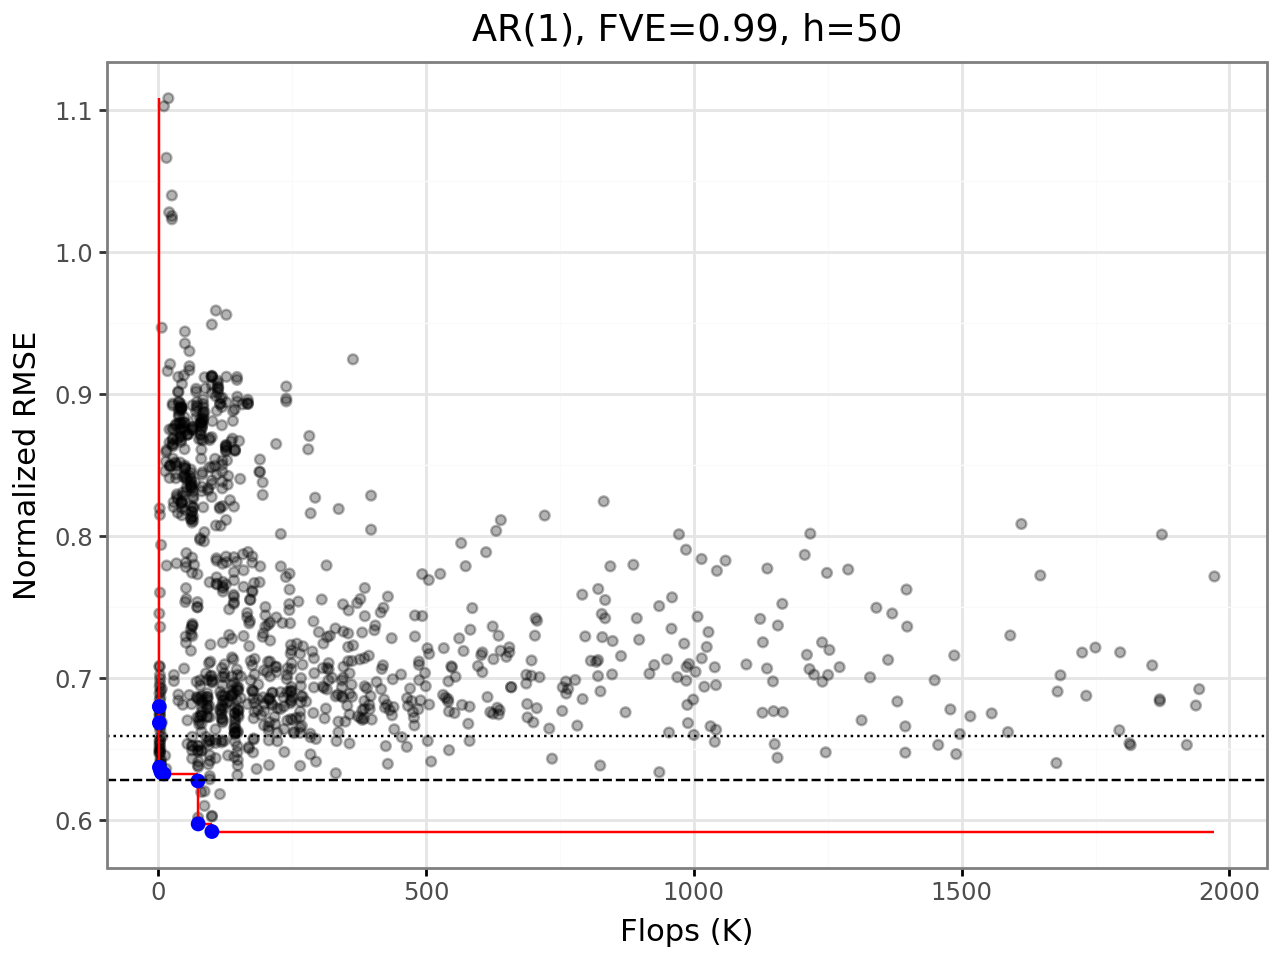

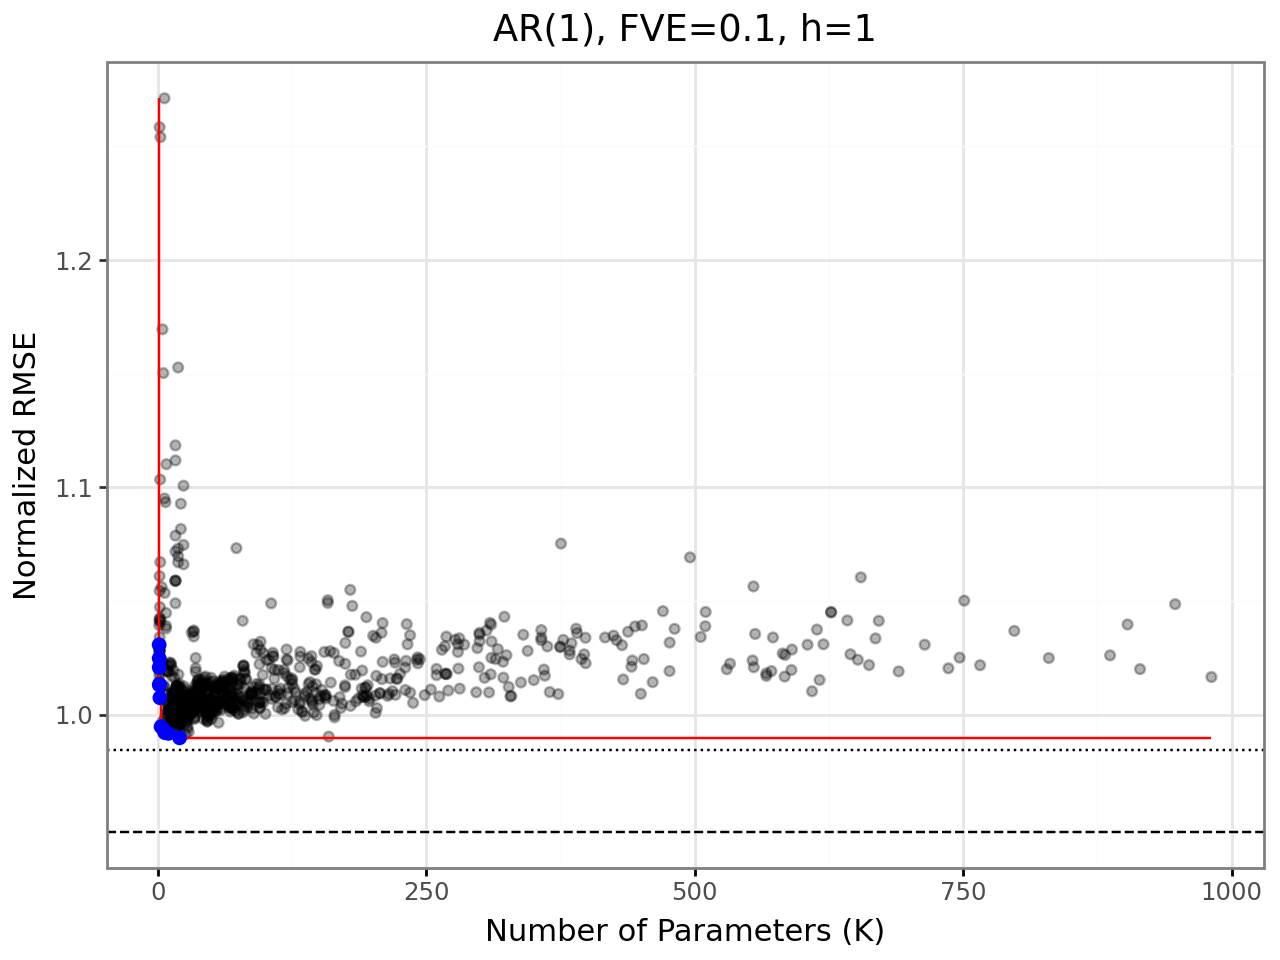

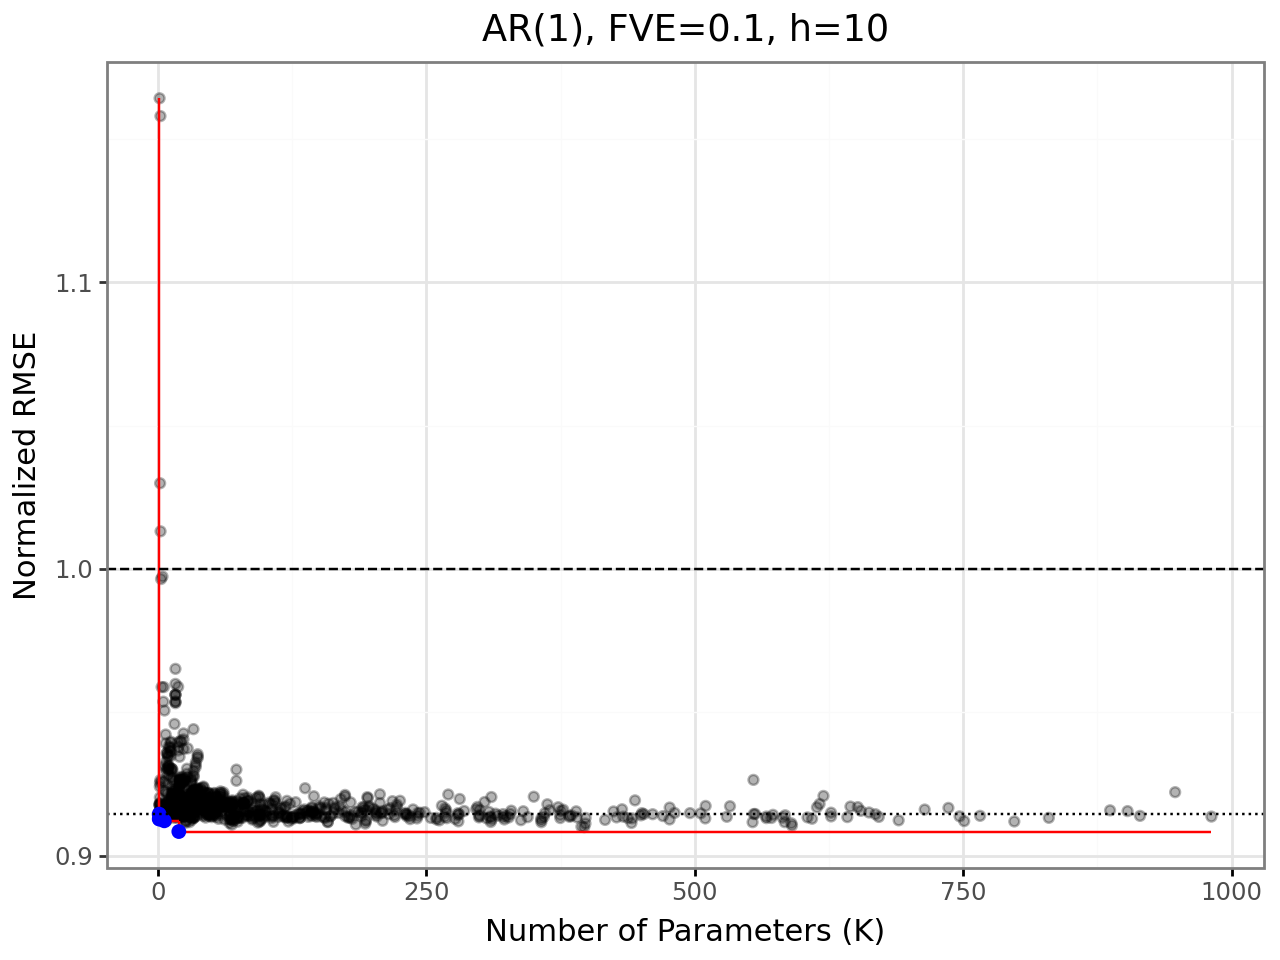

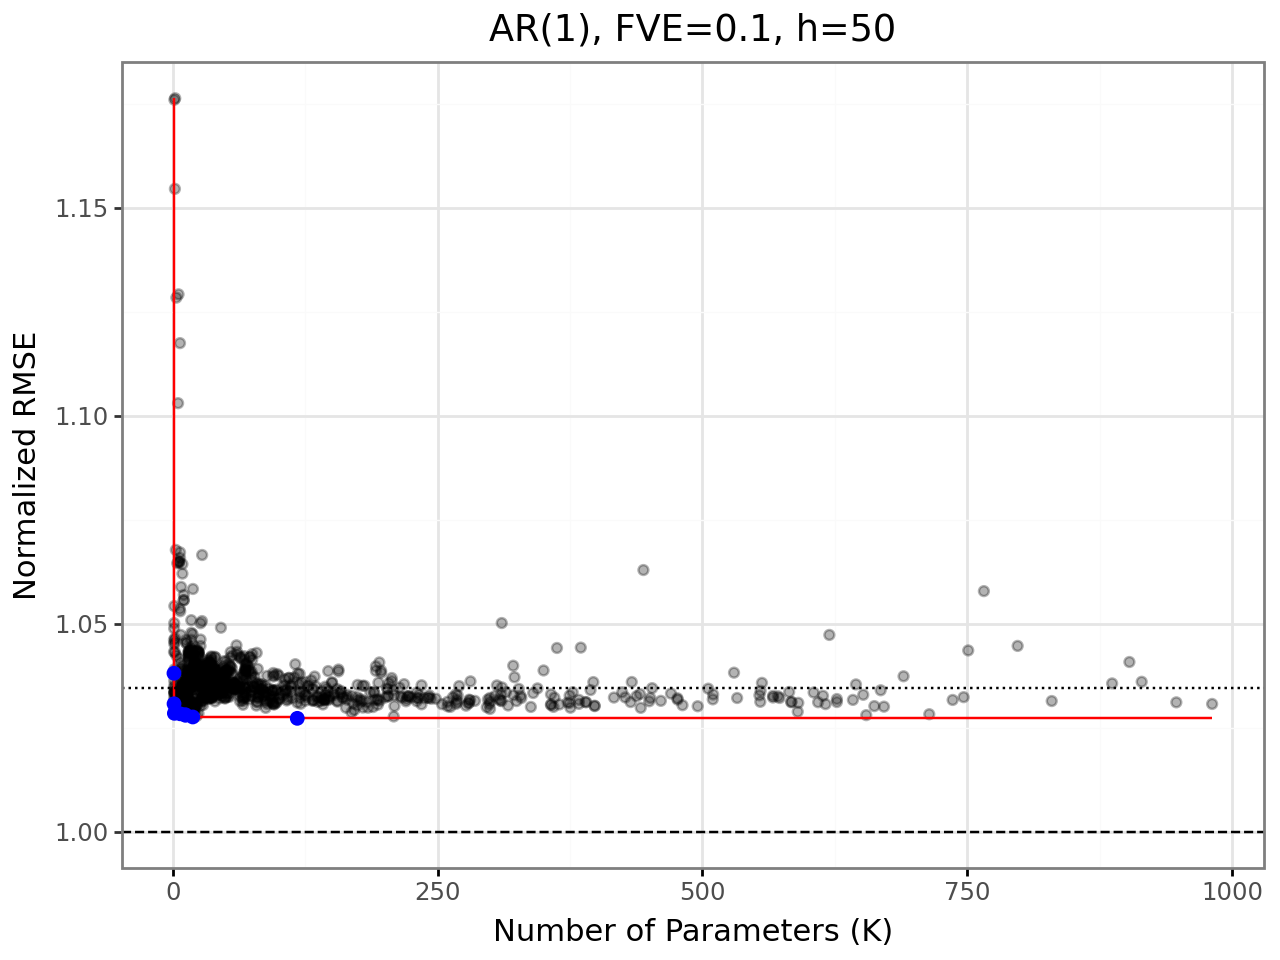

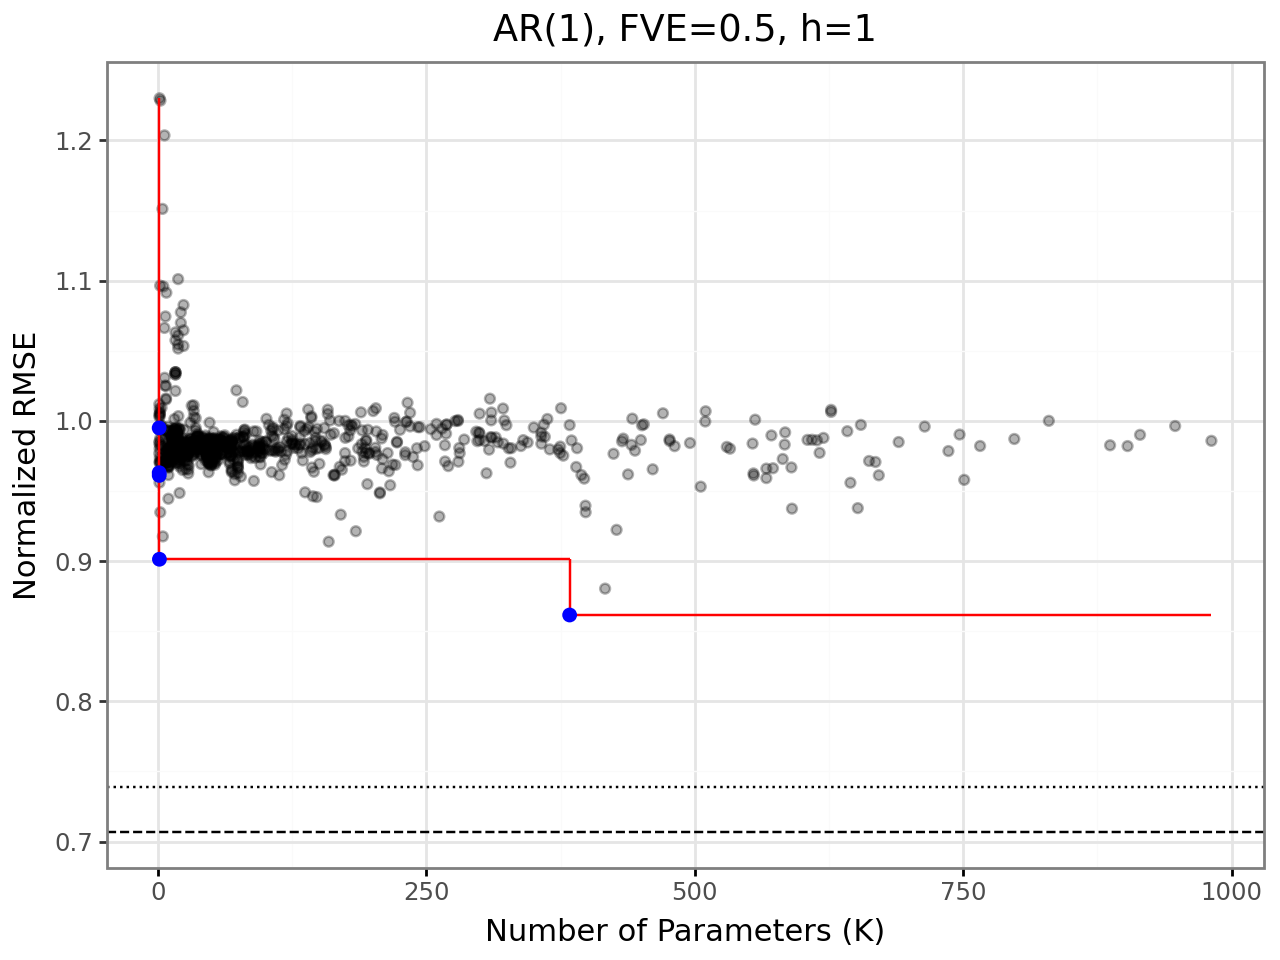

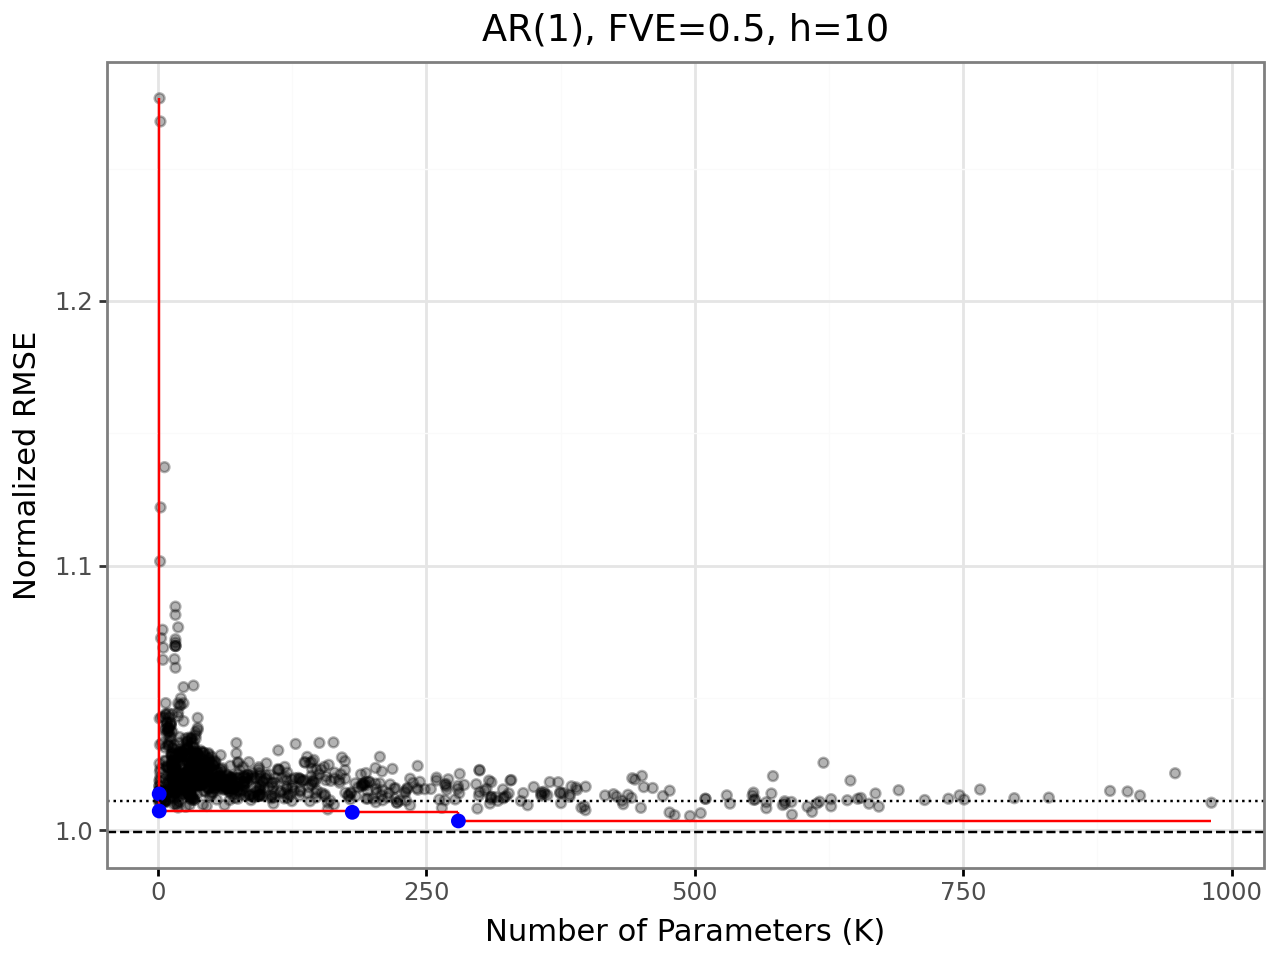

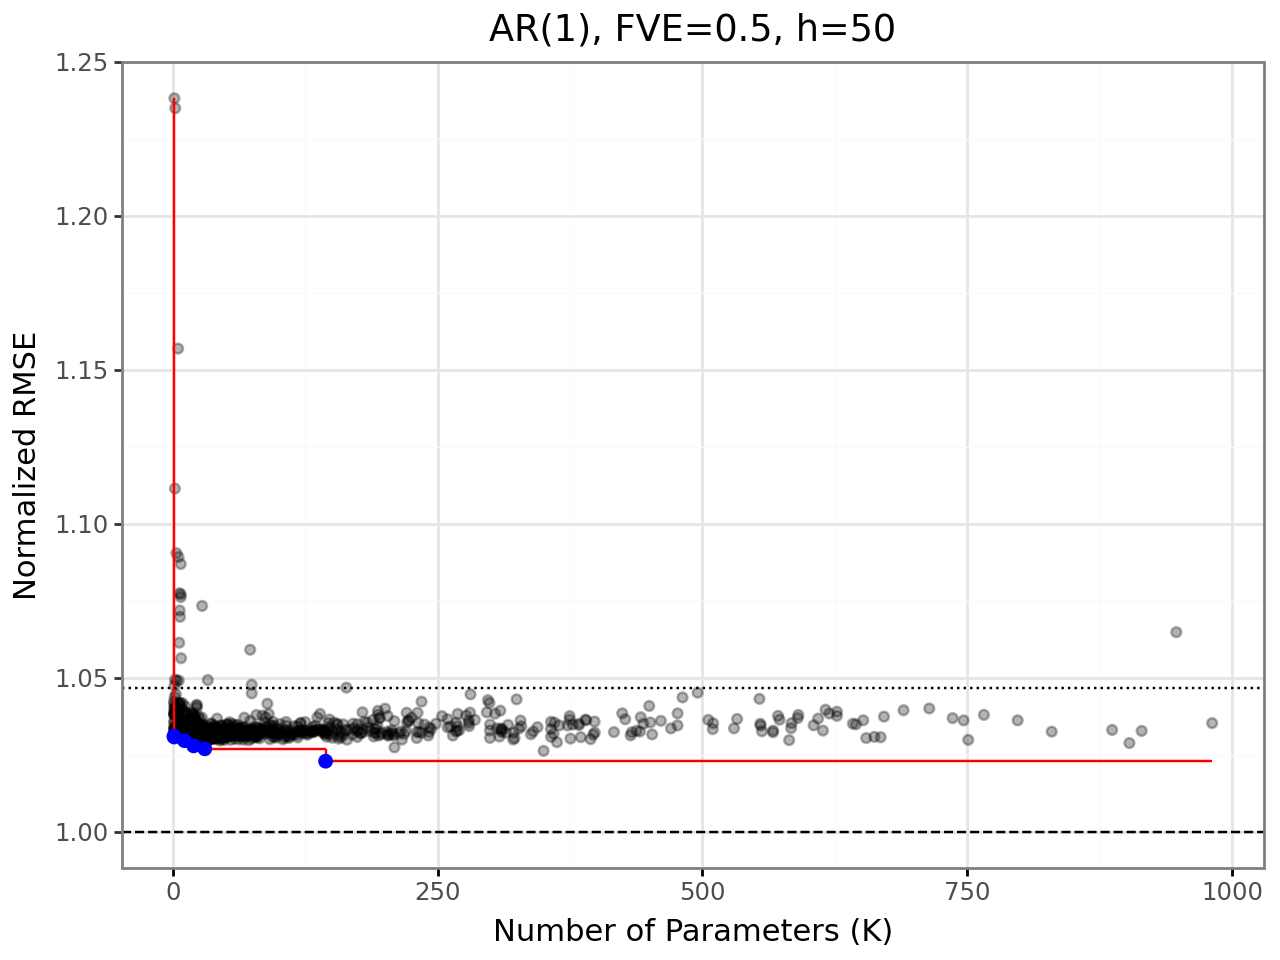

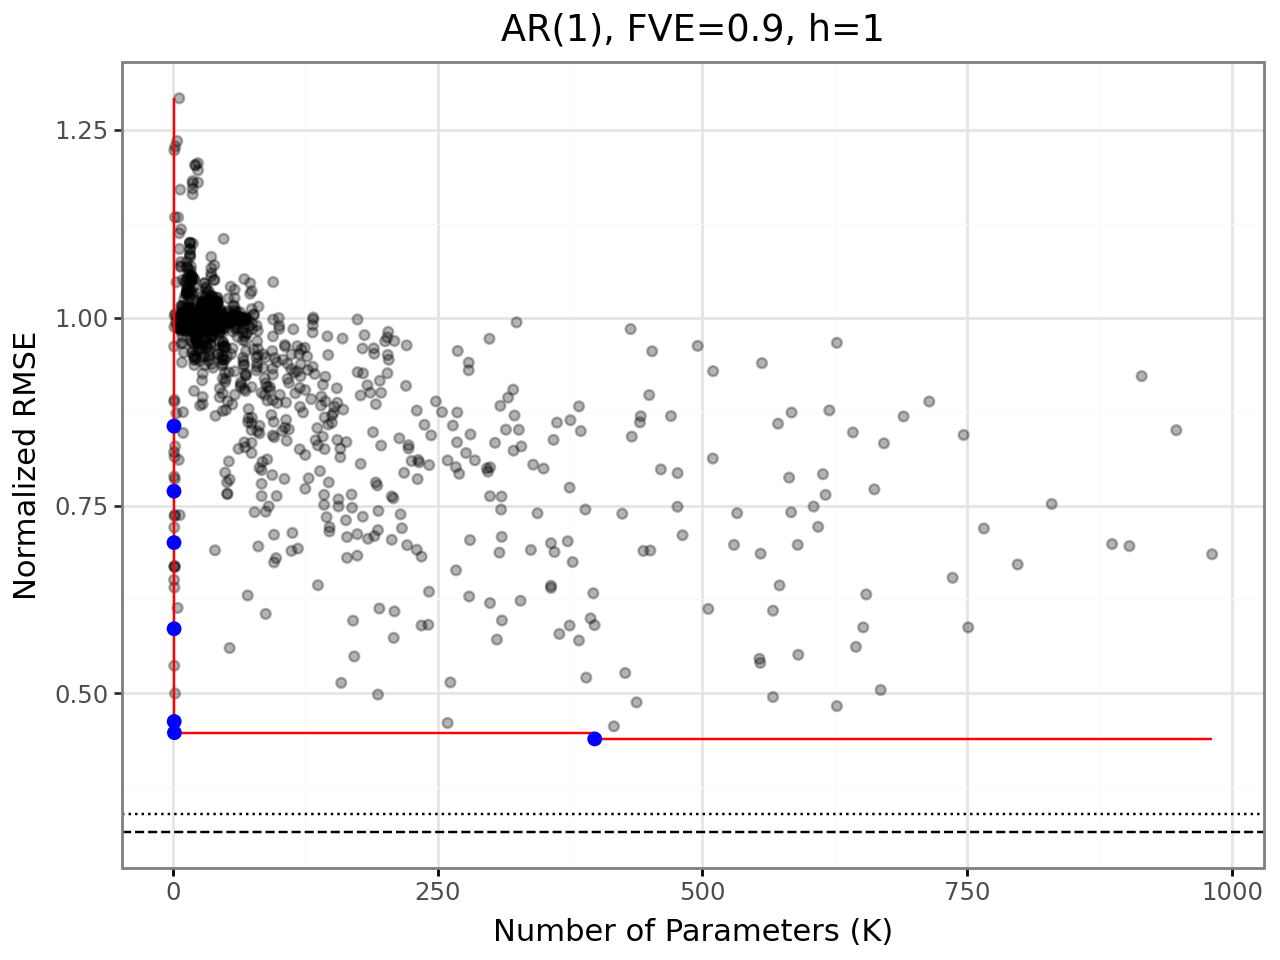

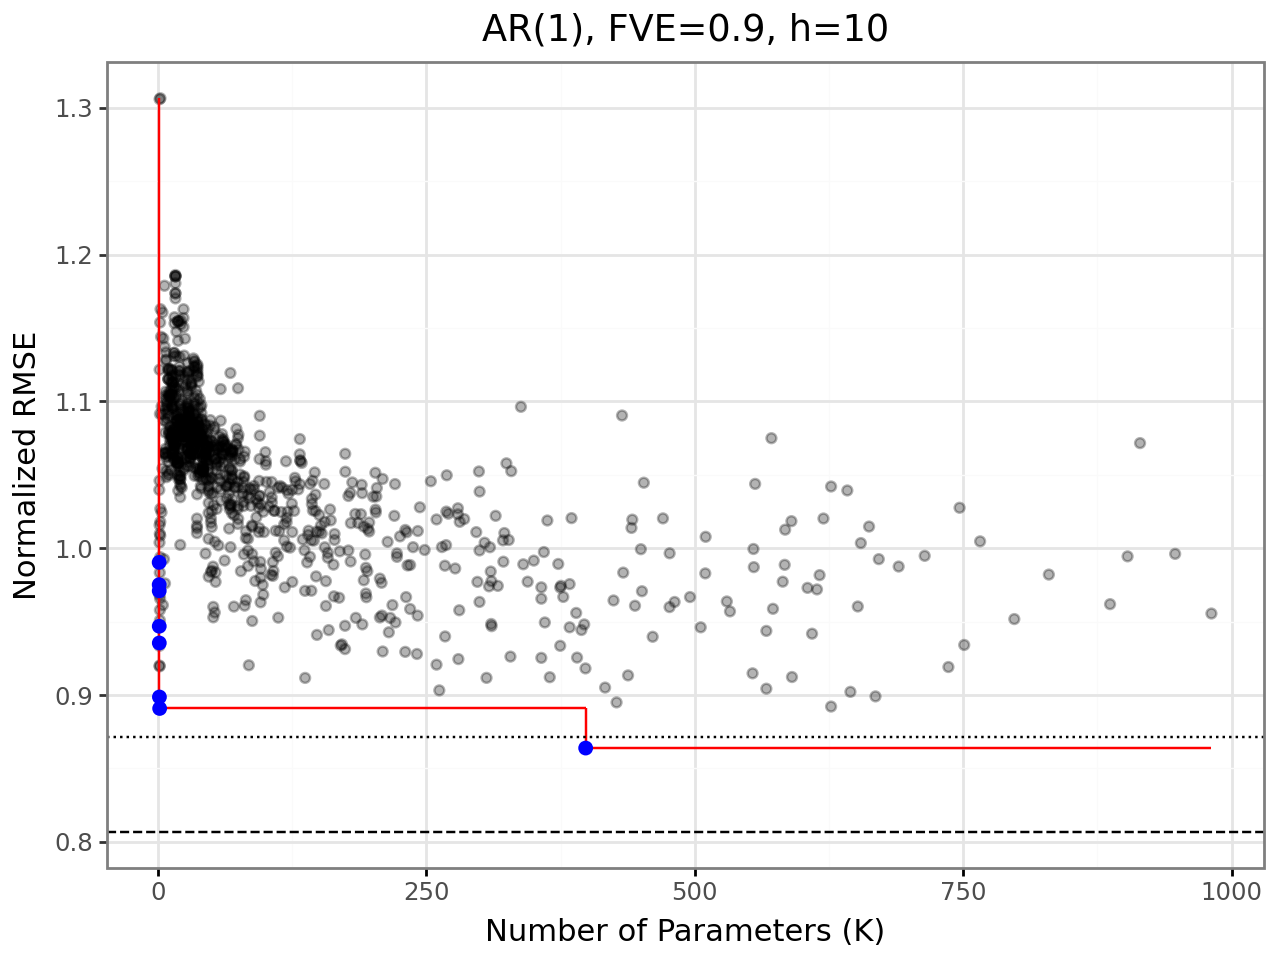

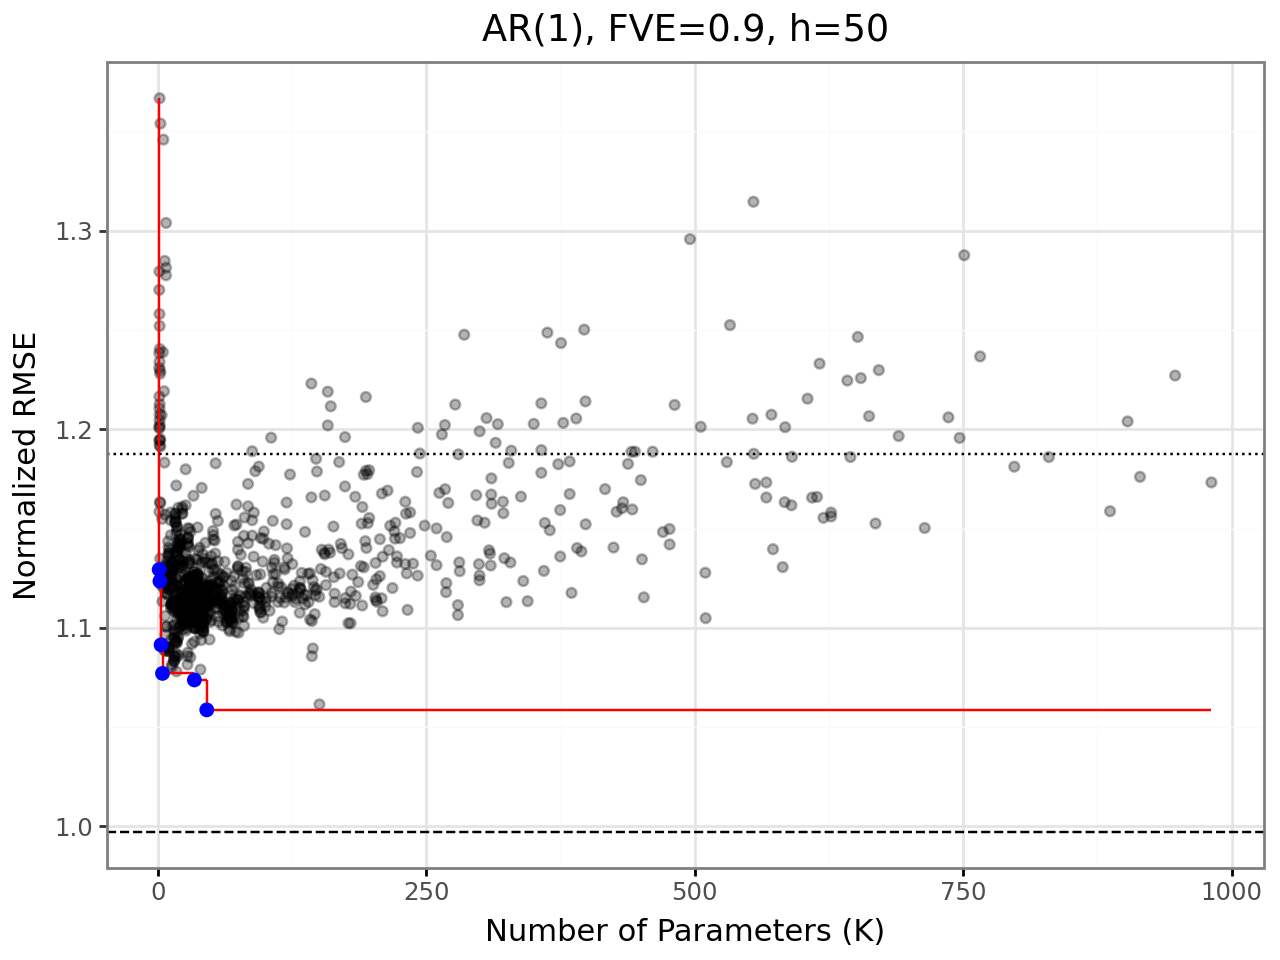

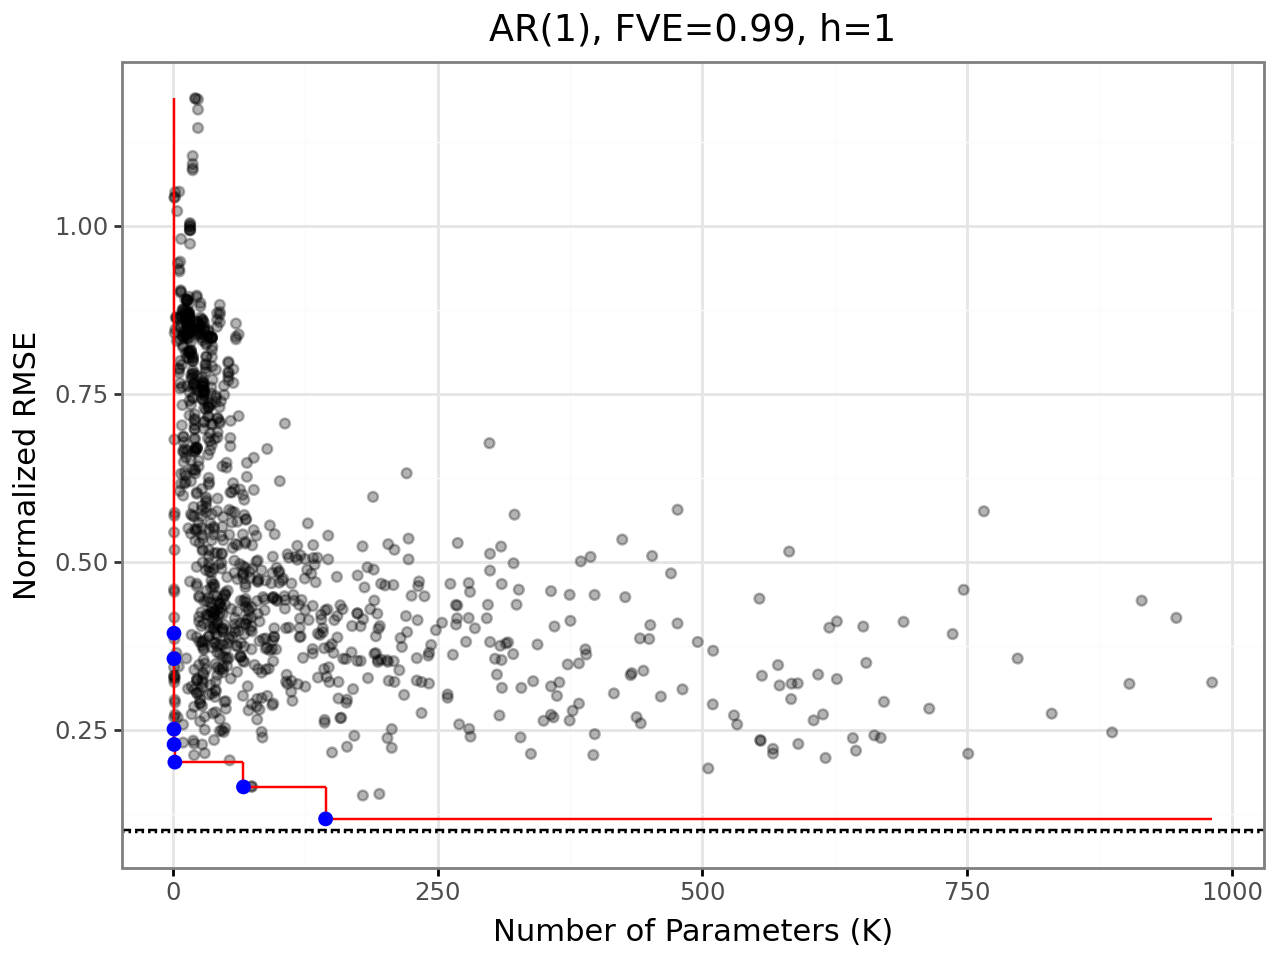

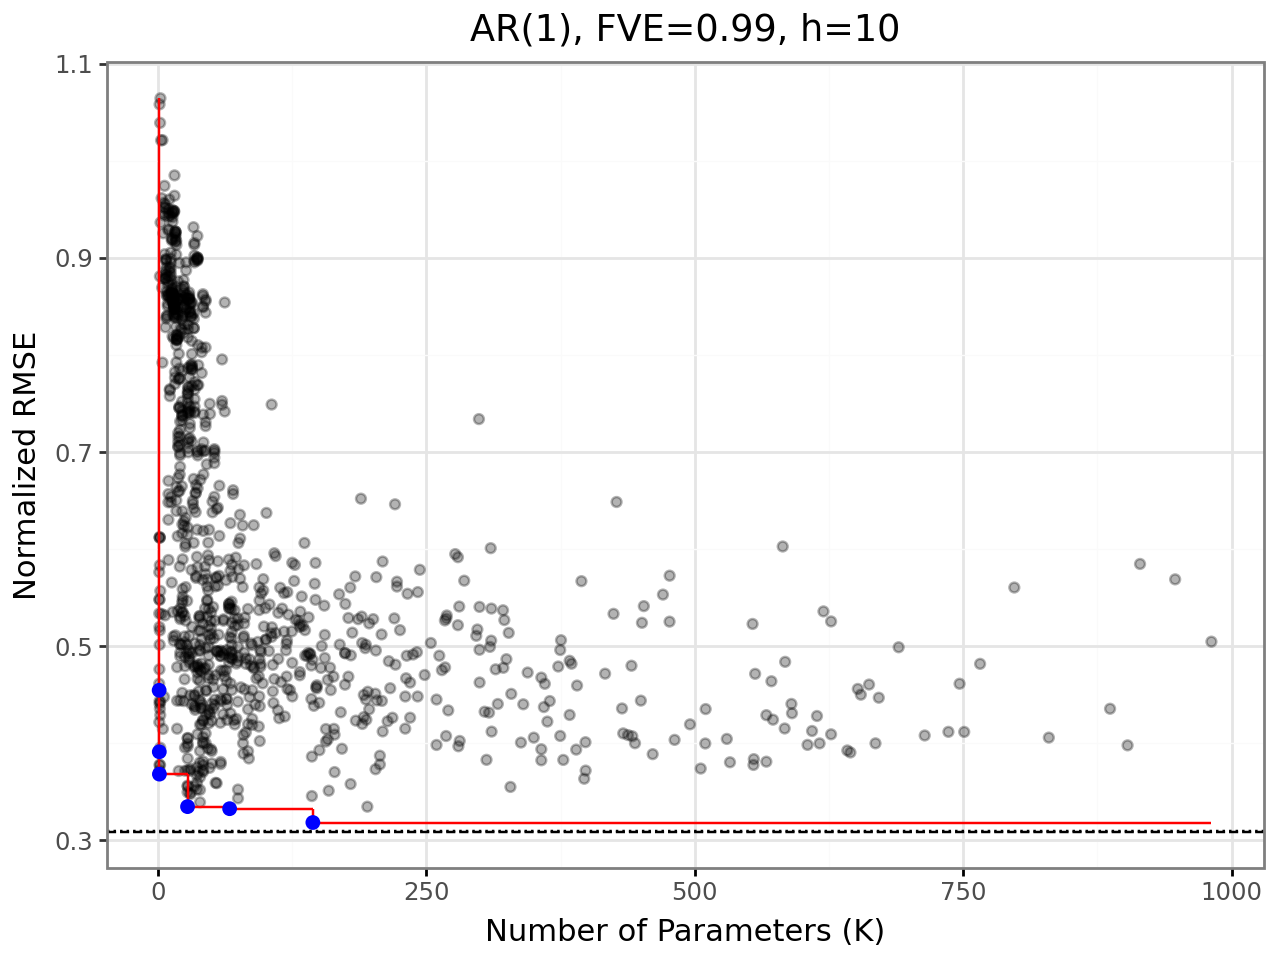

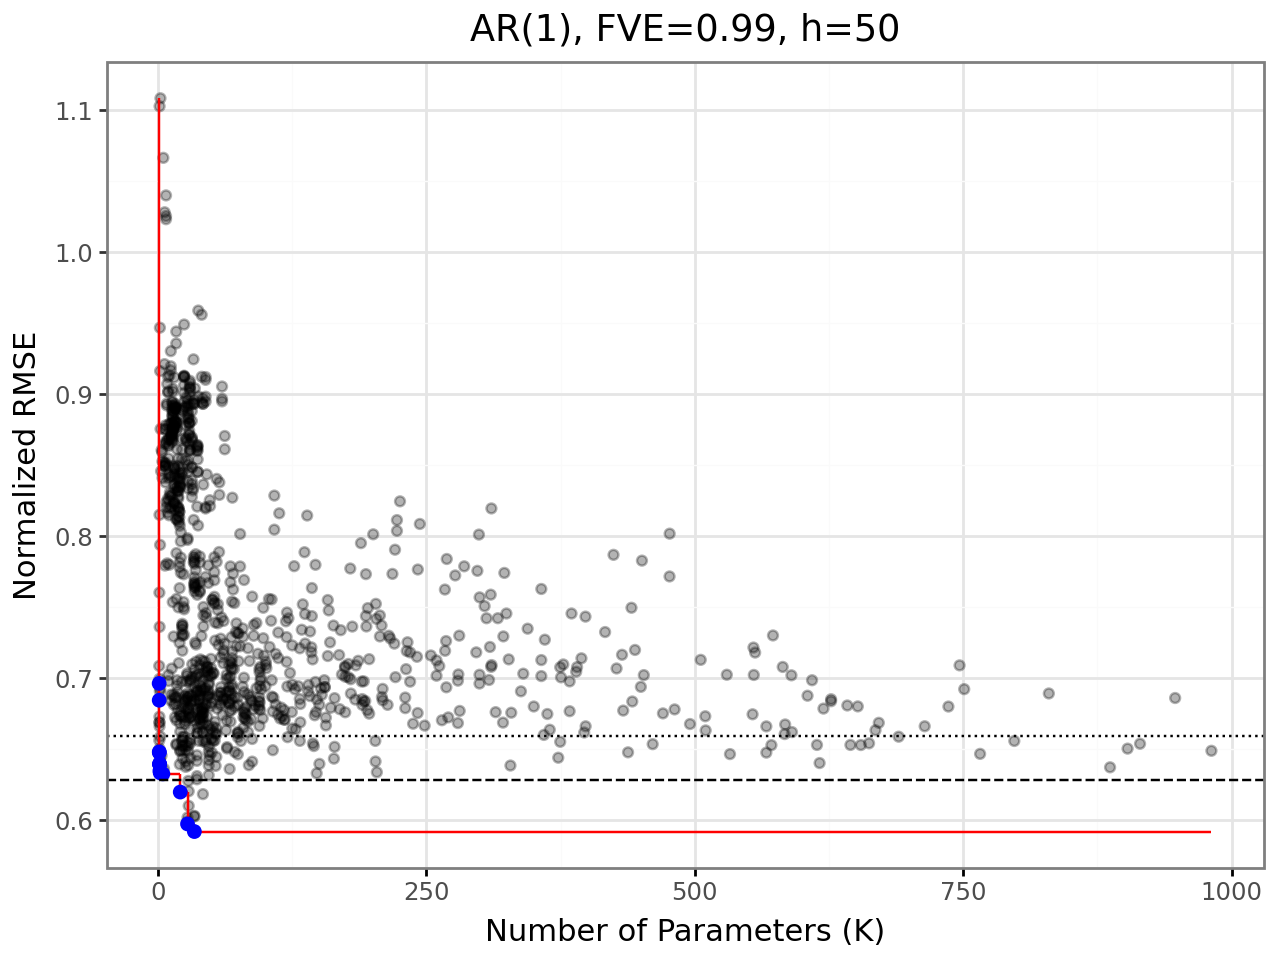

In [132]:
save = False
fves = [0.1, 0.5, 0.9, 0.99]
metrics = ["flops", "num_params"]
hs = [1, 10, 50]
#hs = [50]
for metric in metrics:
    for fve in fves:
        for h in hs:
            fve_df = pd.read_parquet(f"multi_model_1000_{str(fve)}_10000_100_RMSE_0.95_600_1/results.parquet")
            title = f"AR(1), FVE={fve}, h={h}"
            plot, _, _= make_pareto_frontier_plot_ar1(fve_df, [h], metric, title, 0.3, False, True, fve)
            plot.show()
            if save:
                save_as_pdf_pages([plot], f"{title}_{metric}.pdf")

### X-Ray Flux

In [154]:
def make_pareto_frontier_plot2(results: pd.DataFrame, h: list[int], metric: str, title: str, alpha = 1,
                              log_scale: bool=False, add_oracle_NRMSE_line: bool=False, flux_MAD: float=np.nan) -> tuple[ggplot, list[int]]:
    results = results[results["h"].isin(h)].copy()

    
    results = results.groupby(["hyper_idx"]).agg(
        mean_squared_error=("squared_error", "mean"),
        MAD=("squared_error", lambda x: np.median(np.sqrt(x))),
        coverage_accuracy=("coverage_flags", "mean"),
        flops = ("flops", "mean"),
        num_params = ("num_params", "mean"),
    )

    results["normalized_rmse"] = results["MAD"] / flux_MAD
    if metric == "flops":
        xlab = "Flops (K)"
    else:
        xlab = "Number of Parameters (K)"

    results.reset_index(drop=False, inplace=True)
    pareto_hyper_idx, x_b, y_b, x_eb, y_eb= find_pareto_front_hyperidx(results[metric].values, results["normalized_rmse"].values)
    results["boundary_flags"] = results["hyper_idx"].isin(pareto_hyper_idx)
    
    boundary_df = pd.DataFrame({metric: x_b, "normalized_rmse": y_b})
    enhanced_boundary_df = pd.DataFrame({metric: x_eb[:-1], "normalized_rmse": y_eb[:-1],
                                         "metric_end": x_eb[1:], "normalized_rmse_end": y_eb[1:]})
    if len(h) == 1:
        enhanced_boundary_df2 = pd.DataFrame({"h": h[0], "metric": metric,
                                              "x": x_eb[:-1], "normalized_rmse": y_eb[:-1],
                                              "x_end": x_eb[1:], "normalized_rmse_end": y_eb[1:]})
        results["h"] = h[0]
    else:
        enhanced_boundary_df2 = None

    plot = (
        ggplot(results, aes(x = metric, y = "normalized_rmse")) +
        geom_point(alpha = alpha) +
        geom_segment(aes(x = metric, y = "normalized_rmse", xend = "metric_end", yend = "normalized_rmse_end"),
                     data = enhanced_boundary_df, color = "red") +
        geom_point(results[results["boundary_flags"]], color = "blue", size = 2) + 
        labs(x = xlab, y = "Normalized MAD", title=title) +
        theme_bw()
    )

    if log_scale:
        plot = plot + scale_x_log10()

    if add_oracle_NRMSE_line:
        plot = plot + geom_hline(yintercept = np.sqrt(1-fve**min(h)), linetype = "dashed")
    boundary_idx = []

    
    return plot, boundary_idx, enhanced_boundary_df2, results

In [76]:
flux_df = pd.read_parquet("../Xray_Flux/multi_model_1000_0.1_10000_100_RMSE_0.95_600_1/results.parquet")
print(len(flux_df))

10000000


c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 188 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 4 rows containing missing values.


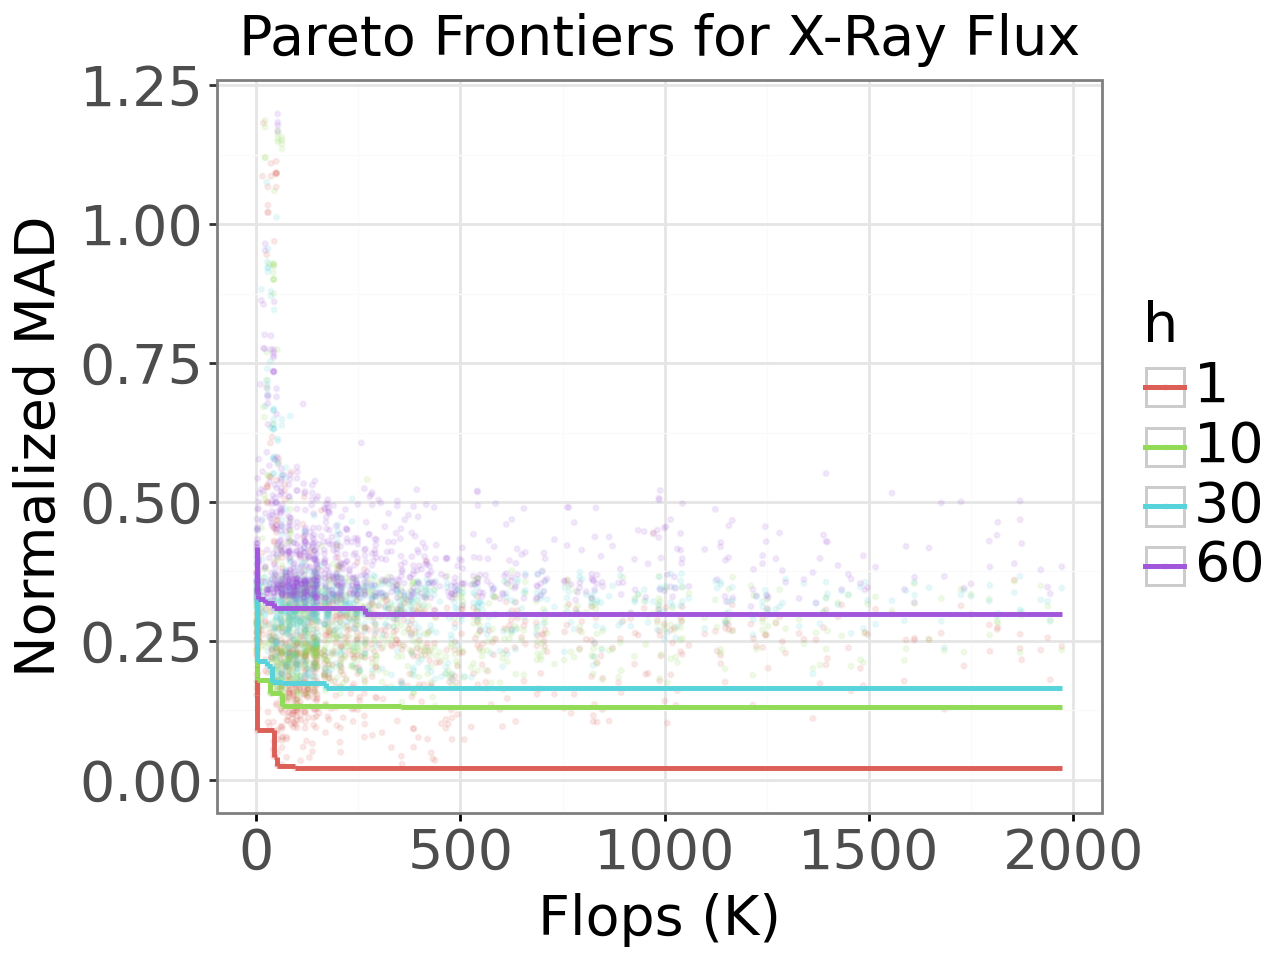

   hyper_idx  mean_squared_error           MAD  coverage_accuracy    flops  \
0          0        9.342233e-12  1.552413e-07               0.96   149.28   
1          1        1.018612e-11  1.625507e-07               0.94   123.32   
2          2        9.391230e-12  1.581574e-07               0.95  1166.42   
3          3        1.016153e-11  1.659266e-07               0.94   137.88   
4          4        9.374589e-12  1.786870e-07               0.96   821.18   

   num_params  normalized_rmse  boundary_flags   h  
0       40.39         0.321506           False  60  
1       37.88         0.336644           False  60  
2      314.46         0.327545           False  60  
3       58.34         0.343635           False  60  
4      357.01         0.370062           False  60  


c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\ggplot.py:779: PlotnineWarning: Filename: Pareto Frontiers for X-Ray Flux.pdf
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 188 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 4 rows containing missing values.


In [170]:
hs = [1, 10, 30, 60]

dfs = []
result_list = []
title = f"Pareto Frontiers for X-Ray Flux"
flux_df = pd.read_parquet("../Xray_Flux/multi_model_1000_0.1_10000_100_RMSE_0.95_600_1/results.parquet")
flux_MAD = np.median(np.abs(flux_df["observed"] - np.median(flux_df["observed"])))
for h in hs:
    _, _, enhanced_boundary_df_2, results = make_pareto_frontier_plot2(flux_df, [h], "flops", "", 0.3, False, False, flux_MAD)
    dfs.append(enhanced_boundary_df_2)
    result_list.append(results)

plot = make_multi_frontier_plot(dfs, title, result_list) + ylab("Normalized MAD") + theme(text=element_text(size=20)) + ylim(0, 1.2)
plot.show()
print(results.head())
save_as_pdf_pages([plot], f"{title}.pdf")

In [103]:
data = flux_df

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


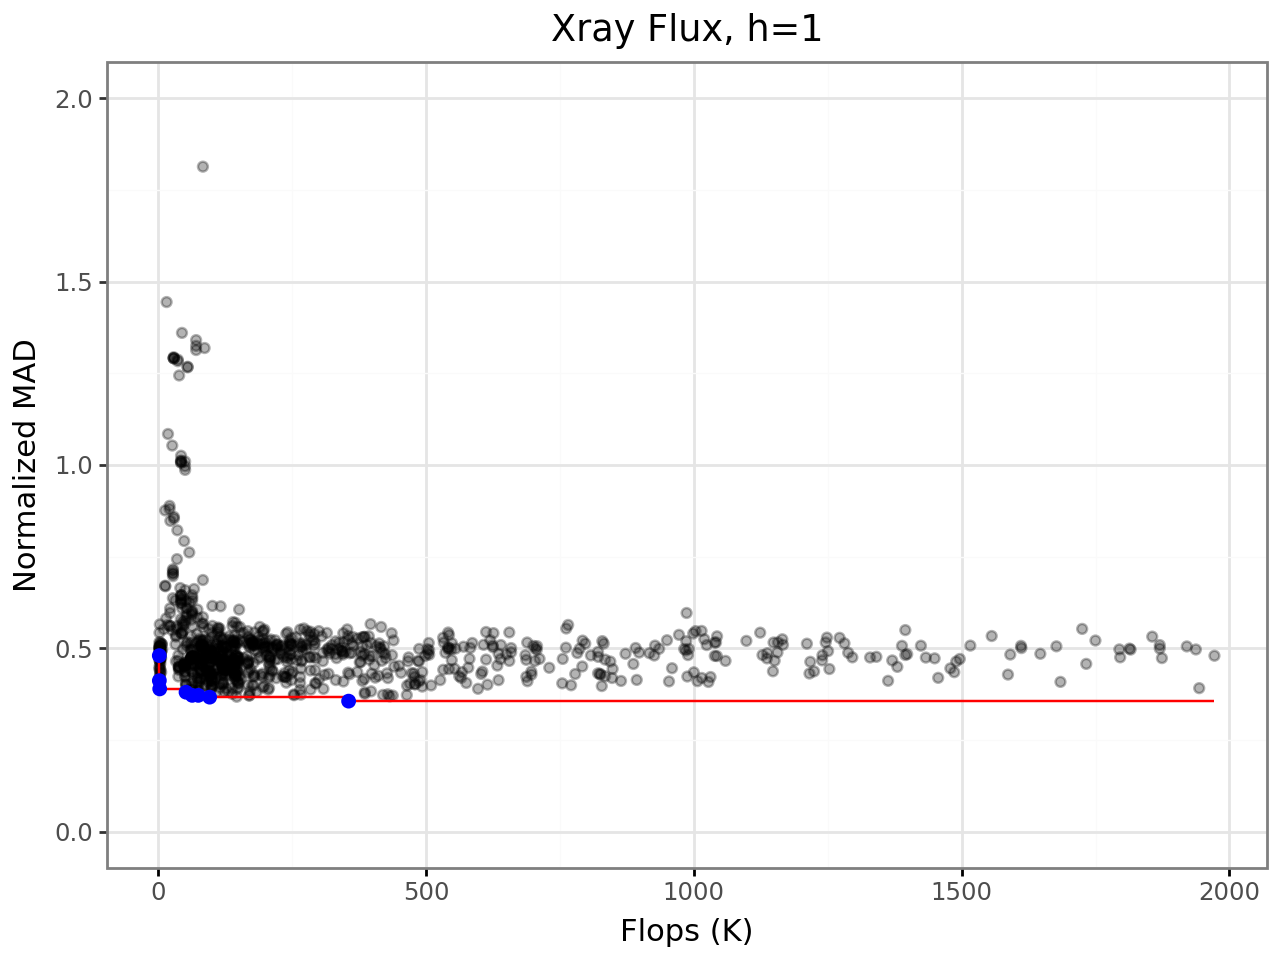

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


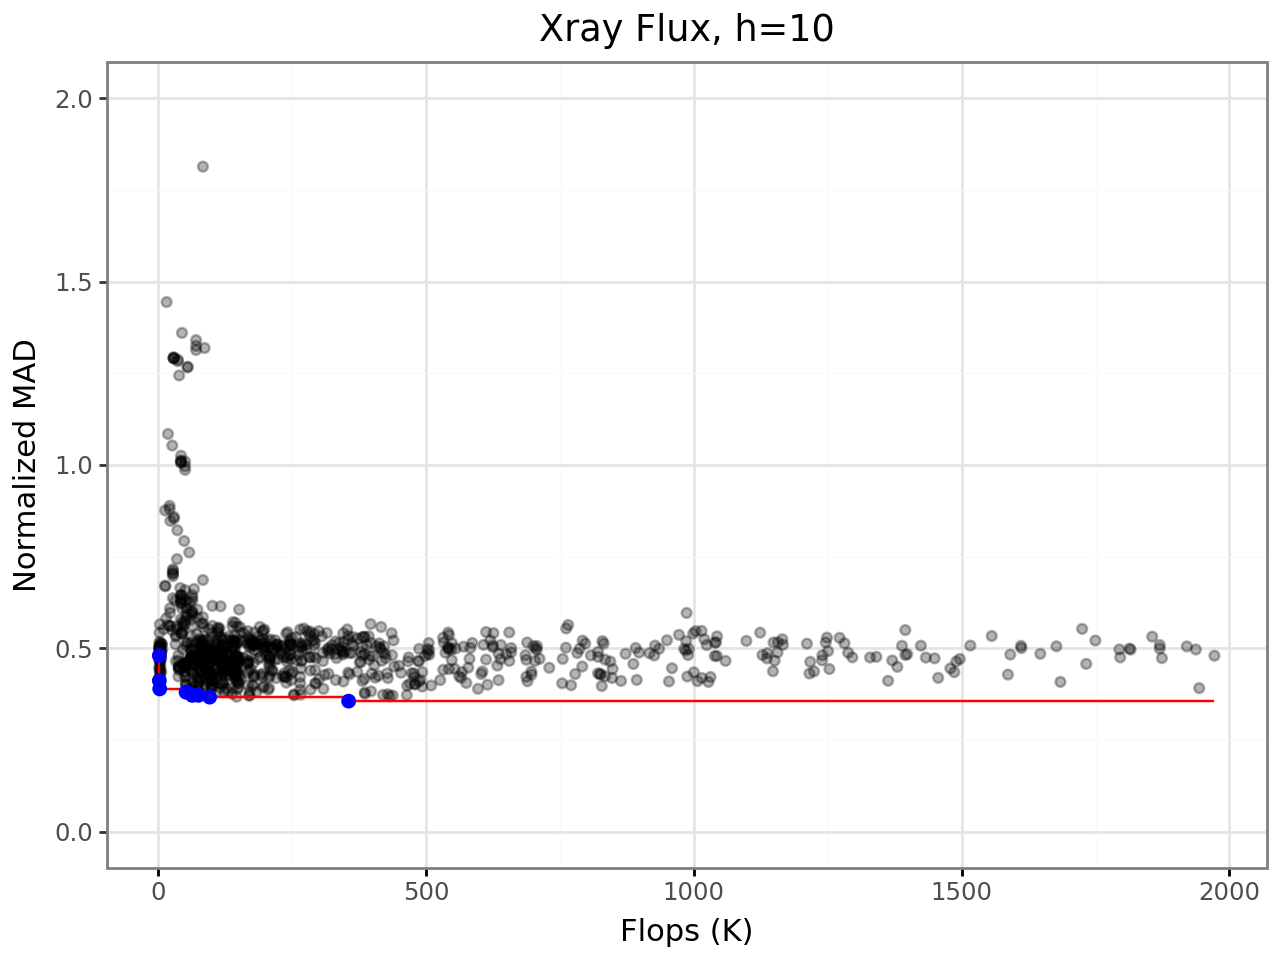

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


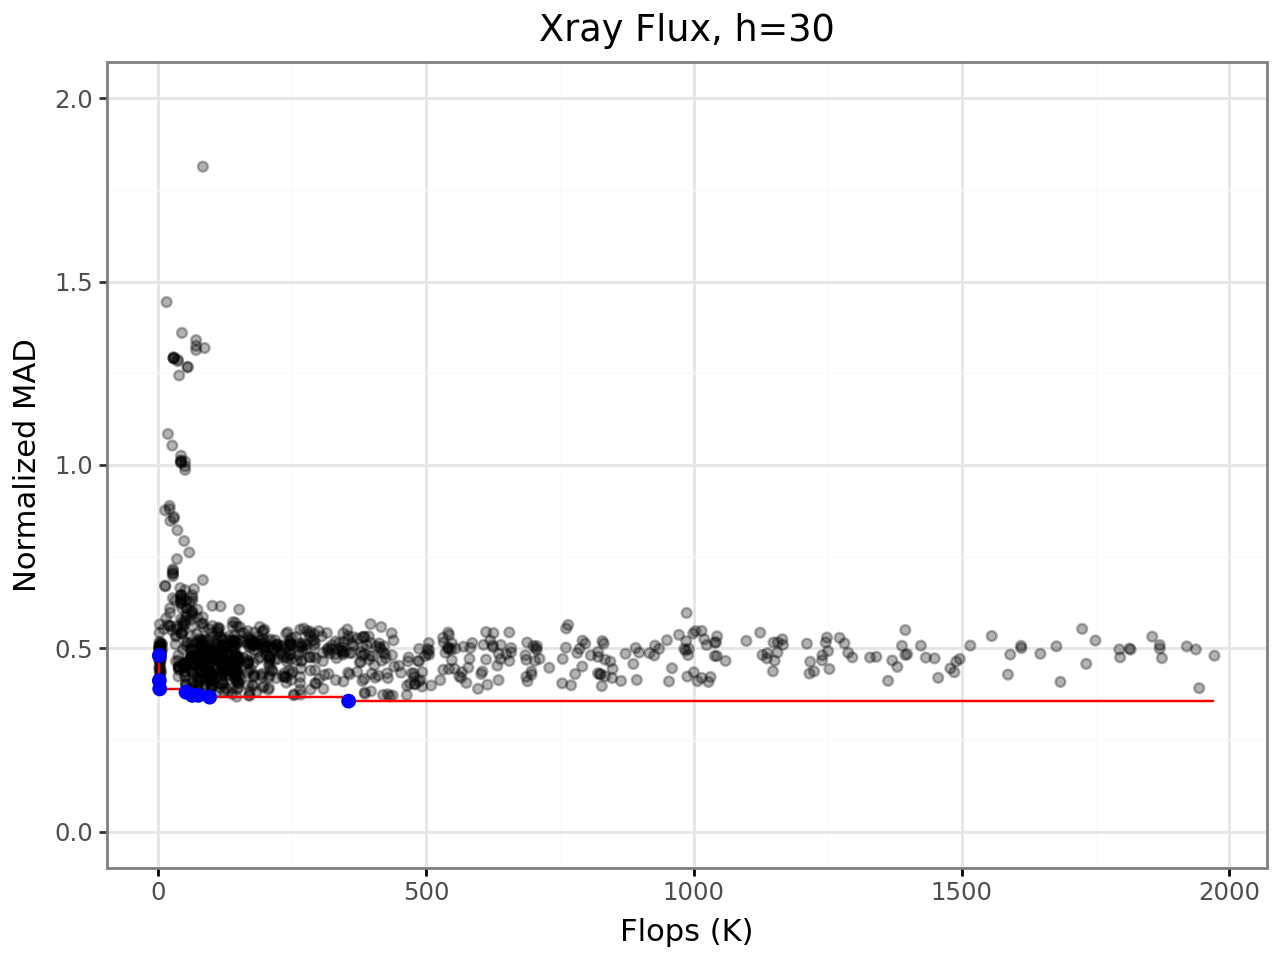

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


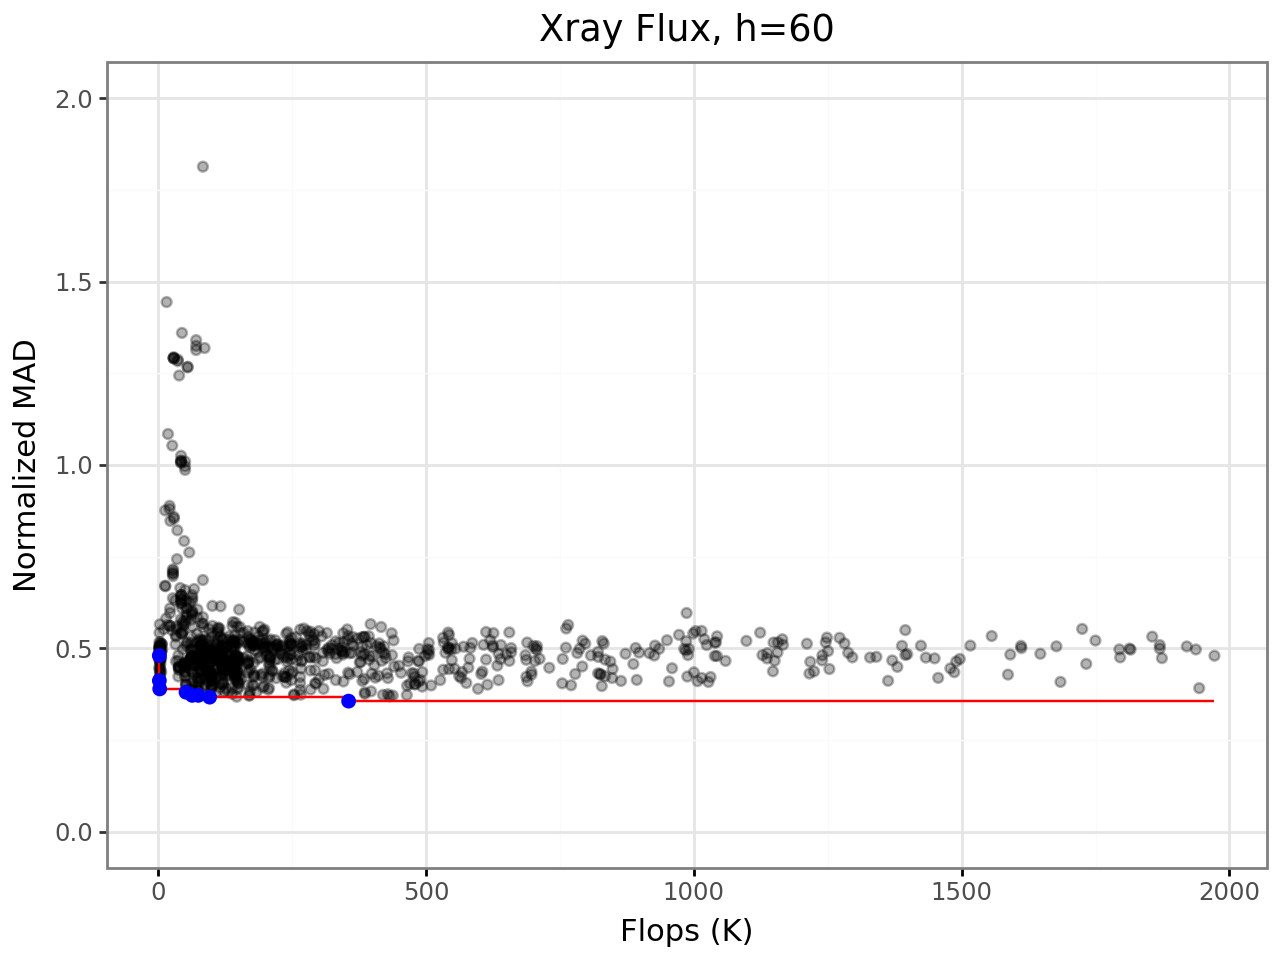

In [135]:
hs = [1, 10, 30, 60]
for h in hs:
    title = f"Xray Flux, h={h}"
    plot, _, _= make_pareto_frontier_plot2(data, [h], "flops", title, 0.3, True, False)
    plot = plot + ylim(0,2)
    plot.show()